In [8]:
#!pip install pyprojroot

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

import sys
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import CondensedNearestNeighbour

import warnings
warnings.filterwarnings('ignore')

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
sys.path.append('/content/drive/MyDrive/DataSci207/birdclef/notebooks/')
base_path = '/content/drive/MyDrive/DataSci207/birdclef/'


# Load data

In [12]:
# Load split data
data_w_split_info = pd.read_csv((base_path + "data/raw/work_df_w_split_info.csv"))
data_w_split_info['y_class_encoded'] = data_w_split_info['y_species_encoded']

# encode species labels
label_encoder = LabelEncoder()
data_w_split_info['y_species_encoded'] = label_encoder.fit_transform(data_w_split_info['primary_label'])      # numeric code per species
species_names = label_encoder.classes_
data_w_split_info.head()

,primary_label,rating,filename,target,filepath,samplename,class,y_species_encoded,split,y_class_encoded
0,1139490,0.0,1139490/CSA36385.ogg,0,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1139490-CSA36385,Insecta,0,test,2
1,1139490,0.0,1139490/CSA36389.ogg,0,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1139490-CSA36389,Insecta,0,train,2
2,1192948,0.0,1192948/CSA36358.ogg,1,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1192948-CSA36358,Insecta,1,train,2
3,1192948,0.0,1192948/CSA36366.ogg,1,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1192948-CSA36366,Insecta,1,train,2
4,1192948,0.0,1192948/CSA36373.ogg,1,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1192948-CSA36373,Insecta,1,val,2


In [13]:
## Load in spectrogram images
#data=np.load(base_path + 'data/processed/debug_birdclef2025_melspec_5sec_32_32.npy',allow_pickle=True)
#data=np.load(base_path + 'data/processed/birdclef2025_melspec_5sec_256_256.npy',allow_pickle=True)
data=np.load(base_path + 'data/processed/birdclef2025_melspec_5sec_64_64.npy',allow_pickle=True)
graph_dict=data.item()


In [14]:
# separate the data splits from common file

train_species_class_df = data_w_split_info[data_w_split_info['split'] == 'train']
val_species_class_df = data_w_split_info[data_w_split_info['split'] == 'val']
test_species_class_df = data_w_split_info[data_w_split_info['split'] == 'test']
print("train_species_class_df shape=", train_species_class_df.shape)
print("val_species_class_df shape=", val_species_class_df.shape)
print("test_species_class_df shape=", val_species_class_df.shape)



train_species_class_df shape= (17138, 10)
val_species_class_df shape= (5713, 10)
test_species_class_df shape= (5713, 10)


# EDA

In [15]:
#Distribution of Dataset across train, val, test
data_w_split_info['split'].value_counts()

,count
split,
train,17138
test,5713
val,5713


In [16]:
# Distribution of data across each Class
data_w_split_info['class'].value_counts()

,count
class,
Aves,27648
Amphibia,583
Mammalia,178
Insecta,155


In [17]:
# Distribution of Dataset across each Species
data_w_split_info['primary_label'].value_counts()

,count
primary_label,
grekis,990
compau,808
trokin,787
roahaw,709
banana,610
...,...
42113,2
21116,2
1139490,2


In [18]:
species_counts = data_w_split_info["primary_label"].value_counts()
print(f"{list(species_counts.index)[0]} Species has highest samples count :  ", max(species_counts) ,
      f"\n{list(species_counts.index)[-1]} Species has lowest samples count : ", min(species_counts))

top_species = list((species_counts[species_counts > 500]).index)
top_species_class = np.unique(list(data_w_split_info[data_w_split_info["primary_label"].isin(top_species)]["class"]))
print("top_species_class", top_species_class)

high_count_species = list((species_counts[species_counts < 500]).index)
low_count_species = list((species_counts[species_counts < 500]).index)


grekis Species has highest samples count :   990 
64862 Species has lowest samples count :  2
top_species_class ['Aves']


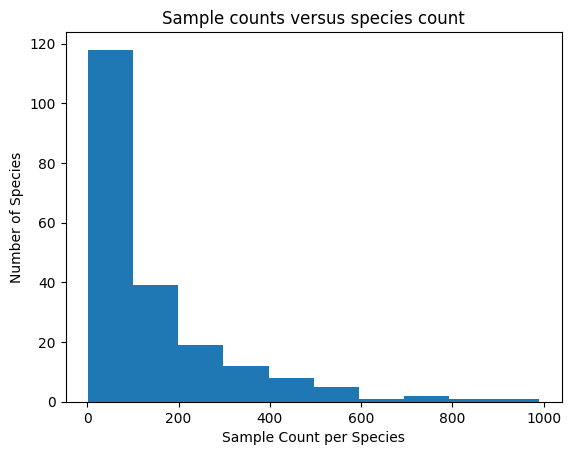

In [19]:
plt.hist(species_counts)
plt.xlabel('Sample Count per Species')
plt.ylabel('Number of Species')
plt.title("Sample counts versus species count")
plt.show()

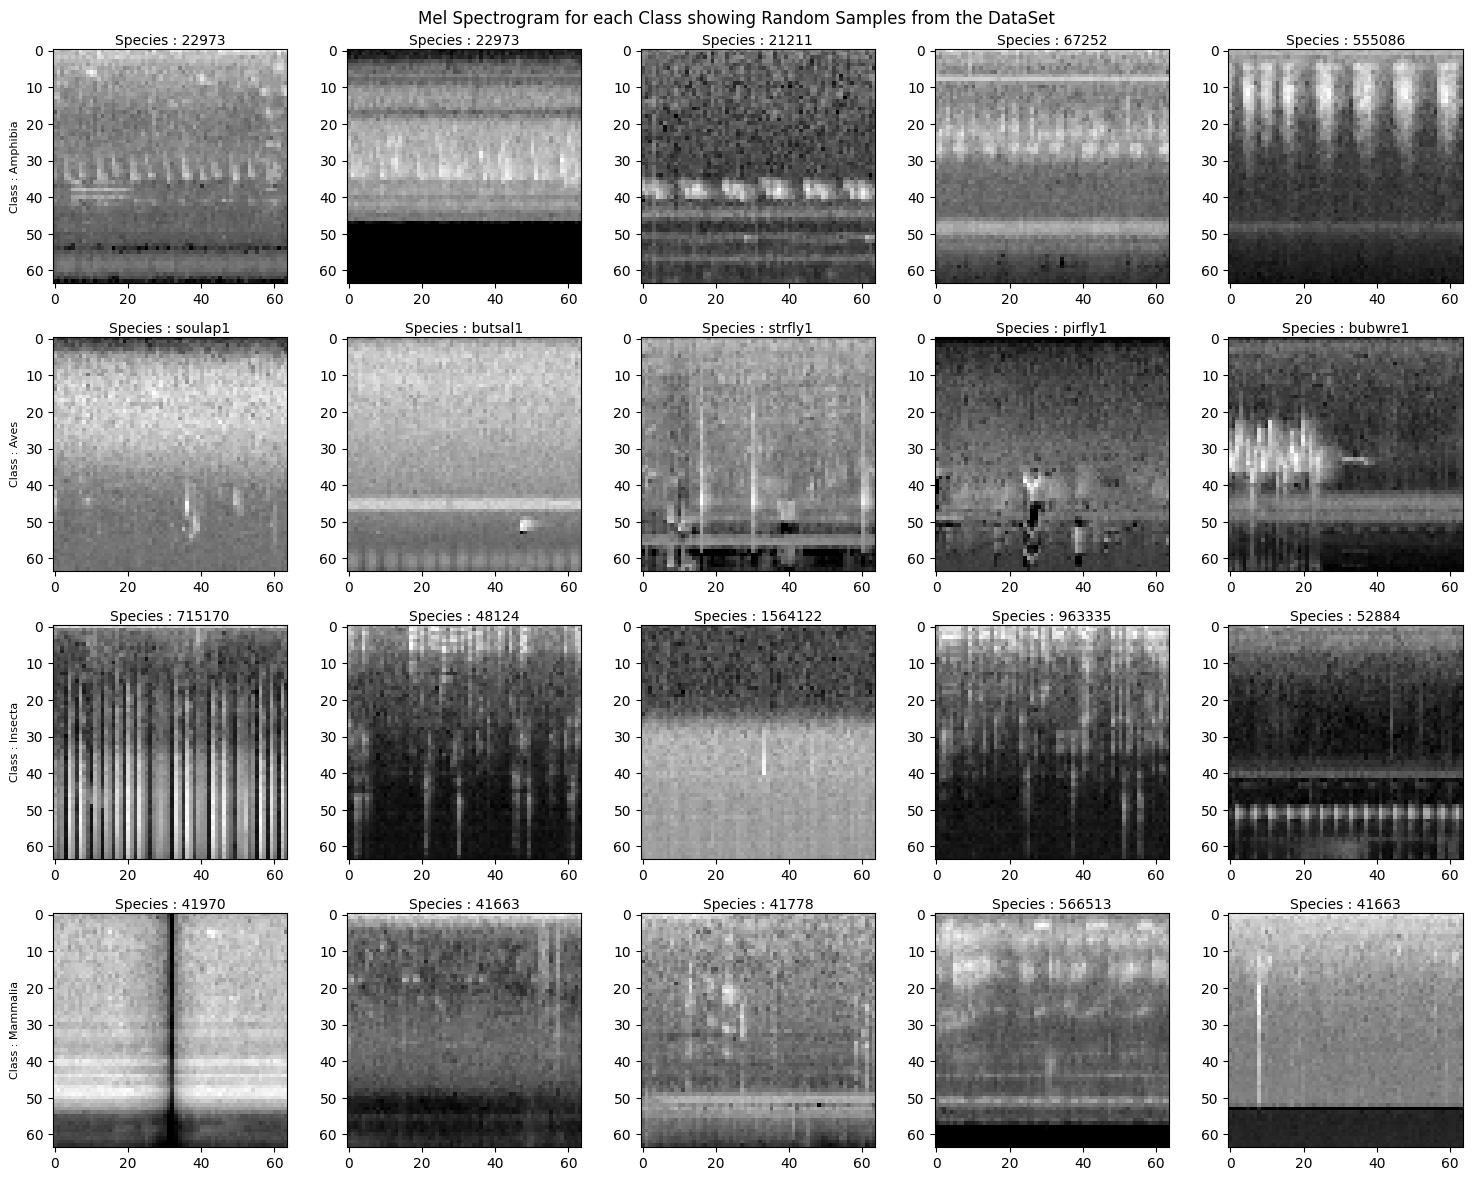

In [20]:
np.random.seed(1234)
class_list = np.unique(data_w_split_info['class'])

rows = len(class_list)
cols = 5
index = 0
fig, axes = plt.subplots(rows,cols, figsize=(cols*3,rows*3))
for row in np.arange(rows):
    df = data_w_split_info[data_w_split_info['class'] == class_list[row]]
    random_samples = random.sample(sorted(np.array(df[df['primary_label'].isin(high_count_species)]['samplename'])), 5)
    for col in np.arange(cols):
        ax = axes[row,col]
        ax.imshow(graph_dict[random_samples[col]], cmap='gray')
        species_name = data_w_split_info[data_w_split_info['samplename'] == random_samples[col]]['primary_label']
        if col == 0:
          class_title = "Class : " + class_list[row]
          ax.set_ylabel(class_title, fontsize=8)
        species_title = "Species : " + list(species_name)[0]
        ax.set_title(species_title, fontsize=10, va='center')
        index += 1
plt.suptitle("Mel Spectrogram for each Class showing Random Samples from the DataSet")
plt.tight_layout()
#plt.subplots_adjust(top=0.9)
plt.show()


Observations: We observe the images for the same class look quite different for different species.  Images across different classes appear to be similar. Difficult task to classifiy these images.

# Baseline Predictions

In [21]:
#Baseline Class Predictions
class_counts = train_species_class_df['class'].value_counts()
#Identify class with most audio samples in training dataset
class_list = list(np.unique(train_species_class_df['class']))
majority_class = list(class_counts.index)[0]
print(f"{majority_class} class  has highest samples count :  ", int(class_counts.values[0]))

## Create a baseline model for species classification
y_baseline = ( train_species_class_df['class'] == majority_class).astype(int)
#print('y_baseline=', y_baseline)
## Building baseline
num_majority_class = np.sum(y_baseline == 1)
print(f"Number of samples with {majority_class} class : {num_majority_class}")

num_non_majority_class = np.sum(y_baseline== 0)
print(f"Number of samples with non-{majority_class} class : {num_non_majority_class}")

majority_label = 1 if num_majority_class > num_non_majority_class else 0
print(f"Majority label: {majority_label}")

majority_predictions = np.full(y_baseline.shape, majority_label)
accuracy = np.mean(majority_predictions == y_baseline)
print(f"Accuracy of majority label classifier: {accuracy:.4f}")

def log_loss(y_true, y_pred):
    loss = -np.mean(y_true * np.log(y_pred) +
                    (1.0 - y_true) * np.log(abs(1.0 - y_pred)))
    return loss

#Have to make baseline prediction be non zero so log function can work
baseline_pred = np.ones(y_baseline.shape[0])*(majority_label + 0.1 )
#print('baseline_pred=', baseline_pred)
train_log_loss = log_loss(y_baseline, baseline_pred)
print(f"Log Loss on training data: {train_log_loss:.4f}")


Aves class  has highest samples count :   16588
Number of samples with Aves class : 16588
Number of samples with non-Aves class : 550
Majority label: 1
Accuracy of majority label classifier: 0.9679
Log Loss on training data: -0.0184


In [22]:
#Baseline Species Prediction

#Identify species with most audio samples in training dataset
species_list = list(np.unique(train_species_class_df['primary_label']))
majority_species = list(species_counts.index)[0]
minority_species = list(species_counts.index)[-1]
class_name_max = list(train_species_class_df[train_species_class_df['primary_label'] == majority_species]["class"])[0]
print(f"{majority_species} Species from class {class_name_max} has highest samples count :  ", int(species_counts.values[0]))

## Create a baseline model for species classification
y_baseline = ( train_species_class_df['primary_label'] == majority_species).astype(int)

## Building baseline
num_majority_species = np.sum(y_baseline == 1)
print(f"Number of samples with {majority_species} species : {num_majority_species}")

num_non_majority_species = np.sum(y_baseline== 0)
print(f"Number of samples with non-{majority_species} species: {num_non_majority_species}")

majority_label = 1 if num_majority_species > num_non_majority_species else 0
print(f"Majority label: {majority_label}")

majority_predictions = np.full(y_baseline.shape, majority_label)
accuracy = np.mean(majority_predictions == y_baseline)
print(f"Accuracy of majority label classifier: {accuracy:.4f}")

def log_loss(y_true, y_pred):
    loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return loss

#Have to make baseline prediction be non zero so log function can work
baseline_pred = np.ones(y_baseline.shape[0])*(majority_label + 0.1 )

train_log_loss = log_loss(y_baseline, baseline_pred)
print(f"Log Loss on training data: {train_log_loss:.4f}")


grekis Species from class Aves has highest samples count :   990
Number of samples with grekis species : 597
Number of samples with non-grekis species: 16541
Majority label: 0
Accuracy of majority label classifier: 0.9652
Log Loss on training data: 0.1819


We observe that baseline model has very high accuracy due to unbalanced data.

# Preparing data for ML

## Preparing Datasets

In [23]:
## Prep data for ML

def one_hot_encode_y(encoded_y, num_classes):
  #One hot encode the y labels
  return to_categorical(encoded_y, num_classes)

X_common_train, X_common_val, X_common_test  = [], [], []
y_species_train, y_species_val, y_species_test  = [], [], []
y_class_train, y_class_val, y_class_test  = [], [], []

# One hot encode y labels
y_species_categorical = to_categorical(data_w_split_info['y_species_encoded'],
                               num_classes = len(np.unique(data_w_split_info['y_species_encoded'])))
y_class_categorical = to_categorical(data_w_split_info['y_class_encoded'],
                               num_classes = len(np.unique(data_w_split_info['y_class_encoded'])))
counter = 0
while counter <  data_w_split_info.shape[0]:
      sample = data_w_split_info.iloc[counter]
      img = graph_dict.get(sample['samplename'])
      #Add 1 color channel to grayscale image so we can use with CNN
      img = img.reshape(img.shape + (1,))
      if sample['split'] == 'train':
        X_common_train.append(img)
        y_species_train.append(sample['y_species_encoded'])
        y_class_train.append(sample['y_class_encoded'])
      elif sample['split'] == 'val':
        X_common_val.append(img)
        y_species_val.append(sample['y_species_encoded'])
        y_class_val.append(sample['y_class_encoded'])
      else :
        X_common_test.append(img)
        y_species_test.append(sample['y_species_encoded'])
        y_class_test.append(sample['y_class_encoded'])
      counter += 1
X_common_train = np.array(X_common_train)
X_common_val = np.array(X_common_val)
X_common_test = np.array(X_common_test)

#One hot encode the y labels
num_species = 206
num_classes = len(np.unique(y_class_train))
print("num_species = ", num_species , "\nnum_classes = ", num_classes)

y_species_train = one_hot_encode_y(np.array(y_species_train),num_species )
y_species_val = one_hot_encode_y(np.array(y_species_val),num_species )
y_species_test = one_hot_encode_y(np.array(y_species_test),num_species )

y_class_train = one_hot_encode_y(np.array(y_class_train),num_classes )
y_class_val = one_hot_encode_y(np.array(y_class_val),num_classes )
y_class_test = one_hot_encode_y(np.array(y_class_test),num_classes )


#Set Random Seed
tf.random.set_seed(1234)
np.random.seed(1234)

# shuffle data
rng = np.random.default_rng(seed=1234)
shuffled_indices_train = rng.permutation(range(X_common_train.shape[0]))
shuffled_indices_val = rng.permutation(range(X_common_val.shape[0]))
shuffled_indices_test = rng.permutation(range(X_common_test.shape[0]))

# shuffle data #
##################
X_common_train = X_common_train[shuffled_indices_train]
y_species_train = y_species_train[shuffled_indices_train]
y_class_train = y_class_train[shuffled_indices_train]

X_common_val = X_common_val[shuffled_indices_val]
y_species_val = y_species_val[shuffled_indices_val]
y_class_val = y_class_val[shuffled_indices_val]

X_common_test = X_common_test[shuffled_indices_test]
y_species_test = y_species_test[shuffled_indices_test]
y_class_test = y_class_test[shuffled_indices_test]



print(f'X_common_train shape: {X_common_train.shape}')
print(f'y_species_train shape: {y_species_train.shape}')
print(f'y_class_train shape: {y_class_train.shape}')

print(f'X_common_val shape: {X_common_val.shape}')
print(f'y_species_val shape: {y_species_val.shape}')
print(f'y_class_val shape: {y_class_val.shape}')

print(f'X_common_test shape: {X_common_test.shape}')
print(f'y_species_test shape: {y_species_test.shape}')
print(f'y_class_test shape: {y_class_test.shape}')

num_species =  206 
num_classes =  4
X_common_train shape: (17138, 64, 64, 1)
y_species_train shape: (17138, 206)
y_class_train shape: (17138, 4)
X_common_val shape: (5713, 64, 64, 1)
y_species_val shape: (5713, 206)
y_class_val shape: (5713, 4)
X_common_test shape: (5713, 64, 64, 1)
y_species_test shape: (5713, 206)
y_class_test shape: (5713, 4)


# Modeling

## Common methods

In [29]:
#Calculate class weights due to class imbalance
unique_classes = np.unique(train_species_class_df['y_class_encoded'])
class_weights_list = compute_class_weight(
                                        class_weight='balanced',
                                        classes=unique_classes,
                                        y=train_species_class_df['y_class_encoded'])

# Convert to a dictionary for Keras/TensorFlow
class_weights_dict = dict(zip(unique_classes,
                              class_weights_list))

class_weights_dict


{np.int64(0): np.float64(12.241428571428571),
 np.int64(1): np.float64(0.258289124668435),
 np.int64(2): np.float64(46.06989247311828),
 np.int64(3): np.float64(40.04205607476636)}

In [30]:
# Plot the loss at each epoch and show final numbers.
def show_history(history):
  """

  """
  # plot loss curves
  hist = history.history
  x_arr = np.arange(len(hist['loss'])) + 1

  fig = plt.figure(figsize=(12, 4))
  ax = fig.add_subplot(1, 3, 1)
  ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
  ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
  ax.legend(fontsize=15)
  ax.set_xlabel('Epoch', size=15)
  ax.set_ylabel('Loss', size=10)
  ax.set_title("Model Loss ")

  ax = fig.add_subplot(1, 3, 2)
  ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
  ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
  ax.legend(fontsize=15)
  ax.set_xlabel('Epoch', size=15)
  ax.set_ylabel('Accuracy', size=10)
  ax.set_title("Model Accuracy")
  ax.set_ylim(0,1)

  ax = fig.add_subplot(1, 3, 3)
  ax.plot(x_arr, hist['f1_score'], '-o', label='Train F1 score.')
  ax.plot(x_arr, hist['val_f1_score'], '--<', label='Val F1 Score.')
  ax.legend(fontsize=15)
  ax.set_xlabel('Epoch', size=15)
  ax.set_ylabel('F1 score', size=10)
  ax.set_title("Model F1 Score ")
  ax.set_ylim(0,1)
  plt.show()

  # evaluate the accuracy of model_tf on train and val datasets
  train_acc = hist['accuracy'][-1]
  val_acc = hist['val_accuracy'][-1]
  print('final train acc: %.3f' %train_acc)
  print('final val acc:   %.3f' %val_acc)
  if int(train_acc ) == 0:
    print("\nUnable to calculate percent diff as Train accuracy is zero")
  else:
    percent_diff = 100*(train_acc - val_acc)/train_acc
    print('\nPercent Diff in Acc. {:.2f}%'.format(percent_diff))


In [31]:
def plot_confusion_matrix(trained_model, train_data, label_data):
  """
  """
  y_hat = trained_model.predict(train_data, verbose=0)

  y_actual = [int(np.argmax(label)) for label in label_data]
  predicted_labels = [int(np.argmax(label)) for label in y_hat]
  print("test_label length : ", len(y_actual))
  print("predicted_labels length : ", len(predicted_labels))
  conf_matrix =  confusion_matrix(y_actual, predicted_labels)
  print("confusion matrix shape=", conf_matrix.shape)

  # Plot normalized confusion matrix
  disp = ConfusionMatrixDisplay.from_predictions(
          y_actual,
          predicted_labels,
          display_labels=['Amphibia' , 'Aves', 'Insecta', 'Mammalia'],
          cmap=plt.cm.Blues,
          normalize='true',
      )
  disp.ax_.set_title("Normalized confusion matrix")
  plt.show()

  #print classification report
  print(classification_report(y_actual, predicted_labels, target_names=['Amphibia' , 'Aves', 'Insecta', 'Mammalia']))

In [32]:
# define an instance of the early_stopping class
early_stopping_acc = tf.keras.callbacks.EarlyStopping(
monitor='val_accuracy',
verbose=1,
patience=3,
mode='max',
restore_best_weights=True)

In [33]:
# define an instance of the early_stopping class
early_stopping_f1 = tf.keras.callbacks.EarlyStopping(
monitor='val_f1_score',
verbose=1,
patience=3,
mode='max',
restore_best_weights=True)

In [34]:
# define an instance of the ReduceLROnPlateau class
reduce_lr_acc = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    mode='max',
    factor=0.5,
    patience=2,
    min_lr=0.00001,
    verbose=1
)

In [35]:
# define an instance of the ReduceLROnPlateau class
reduce_lr_f1 = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_f1_score',
    mode='max',
    factor=0.5,
    patience=2,
    min_lr=0.00001,
    verbose=1
)

# Class Classification

## CNN Modeling for Class level classification

In [36]:

def build_functional_model_1(img_size, output_size):
  """ Model_1 has one convolutional layer followed by a MaxPool and Dropout for Generalization
  """
  tf.keras.backend.clear_session()
  tf.random.set_seed(1234)
  np.random.seed(1234)

  # build model
  image = tf.keras.layers.Input(shape=(img_size, img_size, 1), dtype=tf.float32, name='image')

  conv_1 = tf.keras.layers.Conv2D(filters=img_size,
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_1',
      activation='relu',
      kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4))(image)

  maxpool_1 = tf.keras.layers.MaxPooling2D((2,2))(conv_1)
  dropout_1 = tf.keras.layers.Dropout(rate=0.5)(maxpool_1)
  flat_1 = tf.keras.layers.Flatten()(dropout_1)

  taxonomy_class = tf.keras.layers.Dense(
      units=output_size, activation='softmax', name='taxonomy_class')(flat_1)

  model = tf.keras.Model(inputs=image,
                         outputs=taxonomy_class,
                         name='BirdClef')

  # compile model
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=['accuracy',
               tf.keras.metrics.F1Score(average="macro")])


  # print model_tf summary
  print(model.summary())
  return model

In [37]:
def build_functional_model_2(img_size, output_size):
  """ Model_2 has two blocks of convolutional layer followed by MaxPool and Dropout
  """
  tf.keras.backend.clear_session()
  tf.random.set_seed(1234)
  np.random.seed(1234)

  # build model
  image = tf.keras.layers.Input(shape=(img_size, img_size, 1), dtype=tf.float32, name='image')

  conv_1 = tf.keras.layers.Conv2D(filters=int(img_size/2),
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_1',
      activation='relu')(image)
  maxpool_1 = tf.keras.layers.MaxPooling2D((2,2))(conv_1)
  dropout_1 = tf.keras.layers.Dropout(rate=0.5)(maxpool_1)

  # Add additional convolutional layer
  conv_2 = tf.keras.layers.Conv2D(filters= img_size,
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_2',
      activation='relu')(dropout_1)
  maxpool_2 = tf.keras.layers.MaxPooling2D((2,2))(conv_2)
  dropout_2 = tf.keras.layers.Dropout(rate=0.5)(maxpool_2)

  flat_1 = tf.keras.layers.Flatten()(dropout_2)

  # Add classification layer
  taxonomy_class = tf.keras.layers.Dense(
      units=output_size, activation='softmax', name='taxonomy_class')(flat_1)

  model = tf.keras.Model(inputs=image,
                         outputs=taxonomy_class,
                         name='BirdClef')

  # compile model
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
      loss=tf.keras.losses.CategoricalCrossentropy(),
       metrics=['accuracy',
               tf.keras.metrics.F1Score(average="macro")])


  # print model_tf summary
  print(model.summary())
  return model

In [38]:
def build_functional_model_3(img_size, output_size):
  """ Model_3 has 4 blocks of convolutional layer followed by MaxPool and Dropout
  """
  tf.keras.backend.clear_session()
  tf.random.set_seed(1234)
  np.random.seed(1234)

  # build model
  image = tf.keras.layers.Input(shape=(img_size, img_size, 1), dtype=tf.float32, name='image')

  conv_1 = tf.keras.layers.Conv2D(filters=int(img_size/4),
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_1',
      activation='relu')(image)
  maxpool_1 = tf.keras.layers.MaxPooling2D((2,2))(conv_1)
  dropout_1 = tf.keras.layers.Dropout(rate=0.5)(maxpool_1)

  # Add 2nd convolutional layer
  conv_2 = tf.keras.layers.Conv2D(filters= int(img_size/2),
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_2',
      activation='relu')(dropout_1)
  maxpool_2 = tf.keras.layers.MaxPooling2D((2,2))(conv_2)
  dropout_2 = tf.keras.layers.Dropout(rate=0.5)(maxpool_2)

 # Add 3rd convolutional layer
  conv_3 = tf.keras.layers.Conv2D(filters= img_size,
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_3',
      activation='relu')(dropout_2)
  maxpool_3 = tf.keras.layers.MaxPooling2D((2,2))(conv_3)
  dropout_3 = tf.keras.layers.Dropout(rate=0.5)(maxpool_3)

  # Add 4th convolutional layer
  conv_4 = tf.keras.layers.Conv2D(filters= int(img_size*2),
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_4',
      activation='relu')(dropout_3)
  maxpool_4 = tf.keras.layers.MaxPooling2D((2,2))(conv_4)
  dropout_4 = tf.keras.layers.Dropout(rate=0.5)(maxpool_4)

  # Add a flattening layer
  flat_1 = tf.keras.layers.Flatten()(dropout_4)

  # Add classification layer
  taxonomy_class = tf.keras.layers.Dense(
      units=output_size, activation='softmax', name='taxonomy_class')(flat_1)

  model = tf.keras.Model(inputs=image,
                         outputs=taxonomy_class,
                         name='BirdClef')

  # compile model
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
      loss=tf.keras.losses.CategoricalCrossentropy(),
       metrics=['accuracy',
               tf.keras.metrics.F1Score(average="macro")])


  # print model_tf summary
  print(model.summary())
  return model

In [39]:
def build_functional_model_4(img_size, output_size):
  """ Model_4 has 6 blocks of convolutional layer followed by MaxPool and Dropout
  """
  tf.keras.backend.clear_session()
  tf.random.set_seed(1234)
  np.random.seed(1234)

  # build model
  image = tf.keras.layers.Input(shape=(img_size, img_size, 1), dtype=tf.float32, name='image')

  conv_1 = tf.keras.layers.Conv2D(filters=int(img_size/8),
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_1',
      activation='relu',
      kernel_regularizer=tf.keras.regularizers.L1L2)(image)
  maxpool_1 = tf.keras.layers.MaxPooling2D((2,2))(conv_1)
  dropout_1 = tf.keras.layers.Dropout(rate=0.5)(maxpool_1)

  # Add 2nd convolutional layer
  conv_2 = tf.keras.layers.Conv2D(filters= int(img_size/4),
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_2',
      activation='relu',
      kernel_regularizer=tf.keras.regularizers.L1L2)(dropout_1)
  maxpool_2 = tf.keras.layers.MaxPooling2D((2,2))(conv_2)
  dropout_2 = tf.keras.layers.Dropout(rate=0.5)(maxpool_2)

 # Add 3rd convolutional layer
  conv_3 = tf.keras.layers.Conv2D(filters= int(img_size/2),
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_3',
      activation='relu',
      kernel_regularizer=tf.keras.regularizers.L1L2)(dropout_2)
  maxpool_3 = tf.keras.layers.MaxPooling2D((2,2))(conv_3)
  dropout_3 = tf.keras.layers.Dropout(rate=0.5)(maxpool_3)

  # Add 4th convolutional layer
  conv_4 = tf.keras.layers.Conv2D(filters= img_size,
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_4',
      activation='relu',
      kernel_regularizer=tf.keras.regularizers.L1L2)(dropout_3)
  maxpool_4 = tf.keras.layers.MaxPooling2D((2,2))(conv_4)
  dropout_4 = tf.keras.layers.Dropout(rate=0.5)(maxpool_4)

  # Add 5th convolutional layer
  conv_5 = tf.keras.layers.Conv2D(filters= int(img_size*2),
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_5',
      activation='relu',
      kernel_regularizer=tf.keras.regularizers.L1L2)(dropout_4)
  maxpool_5 = tf.keras.layers.MaxPooling2D((2,2))(conv_5)
  dropout_5 = tf.keras.layers.Dropout(rate=0.5)(maxpool_5)


  # Add 6th convolutional layer
  conv_6 = tf.keras.layers.Conv2D(filters= int(img_size*4),
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_6',
      activation='relu',
      kernel_regularizer=tf.keras.regularizers.L1L2)(dropout_5)
  maxpool_6 = tf.keras.layers.MaxPooling2D((2,2))(conv_6)
  dropout_6 = tf.keras.layers.Dropout(rate=0.5)(maxpool_6)


  # Add a flattening layer
  flat_1 = tf.keras.layers.Flatten()(dropout_6)


  # Add classification layer
  taxonomy_class = tf.keras.layers.Dense(
      units=output_size, activation='softmax', name='taxonomy_class')(flat_1)

  model = tf.keras.Model(inputs=image,
                         outputs=taxonomy_class,
                         name='BirdClef')

  # compile model
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
      loss=tf.keras.losses.CategoricalCrossentropy(),
       metrics=[tf.keras.metrics.Accuracy(),
               tf.keras.metrics.F1Score(average="macro")])


  # print model_tf summary
  print(model.summary())
  return model

### Model 1

Model: "BirdClef"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 64, 64, 64)     │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ taxonomy_class (Dense)          │ (None, 4)              │       262,148 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 263,236 (1.00 MB)

 Trainable params: 263,236 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.3849 - f1_score: 0.1468 - loss: 29.9846 - val_accuracy: 0.0054 - val_f1_score: 0.0027 - val_loss: 1.3840 - learning_rate: 0.1000
Epoch 2/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3388 - f1_score: 0.1349 - loss: 1.3535 - val_accuracy: 0.0054 - val_f1_score: 0.0027 - val_loss: 1.3814 - learning_rate: 0.1000
Epoch 3/20
535/536 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3392 - f1_score: 0.1350 - loss: 1.3510
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.05000000074505806.
536/536 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3388 - f1_score: 0.1349 - loss: 1.3512 - val_accuracy: 0.0054 - val_f1_score: 0.0027 - val_loss: 1.3795 - learning_rate: 0.1000
Epoch 4/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3744 - f1_score: 0.1432 - loss: 1.3370 - val_accuracy: 0.0054 - val_f1_score: 0.0027 - val_loss: 1.4810 - learning_rate: 0.0500
Epoch 4: early stopping
Restoring model weights 

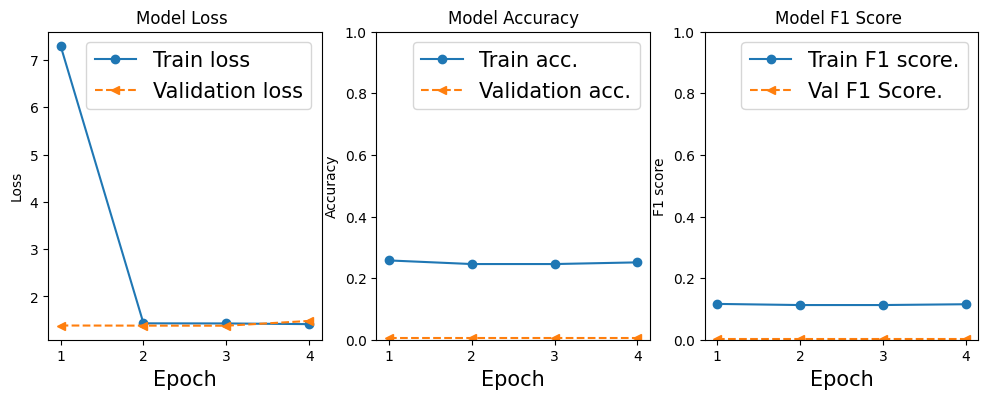

final train acc: 0.251
final val acc:   0.005

Unable to calculate percent diff as Train accuracy is zero
test_label length :  17138
predicted_labels length :  17138
confusion matrix shape= (4, 4)


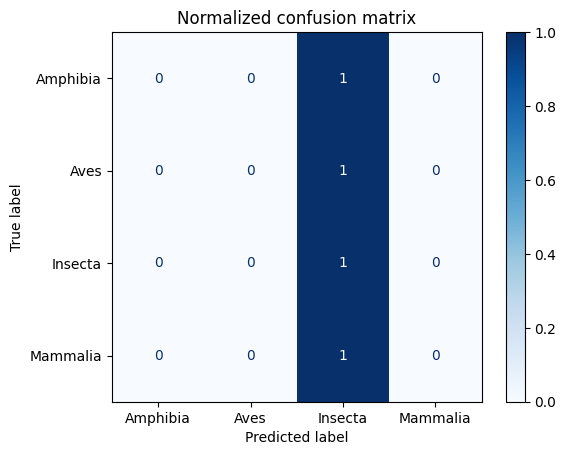

              precision    recall  f1-score   support

    Amphibia       0.00      0.00      0.00       350
        Aves       0.00      0.00      0.00     16588
     Insecta       0.01      1.00      0.01        93
    Mammalia       0.00      0.00      0.00       107

    accuracy                           0.01     17138
   macro avg       0.00      0.25      0.00     17138
weighted avg       0.00      0.01      0.00     17138



In [40]:

class_model_1_func = build_functional_model_1(X_common_train.shape[1],y_class_train.shape[1])
# train model on (X_train, y_train) data
history = class_model_1_func.fit(
    X_common_train,
    y_class_train,
    validation_data=(X_common_val,y_class_val),
    callbacks=[early_stopping_f1, reduce_lr_f1],
    class_weight=class_weights_dict,
    epochs=20)

# plot loss curves
show_history(history)

#plot confusion matrix
plot_confusion_matrix(class_model_1_func, X_common_train, y_class_train)

### Model 2

Model: "BirdClef"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 64, 64, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 32, 32, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ taxonomy_class (Dense)          │ (None, 4)              │        65,540 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,916 (386.39 KB)

 Trainable params: 98,916 (386.39 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.2826 - f1_score: 0.1209 - loss: 95.8001 - val_accuracy: 0.0054 - val_f1_score: 0.0027 - val_loss: 1.3678 - learning_rate: 0.1000
Epoch 2/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3402 - f1_score: 0.1352 - loss: 1.3365 - val_accuracy: 0.0054 - val_f1_score: 0.0027 - val_loss: 1.3668 - learning_rate: 0.1000
Epoch 3/20
528/536 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3264 - f1_score: 0.1312 - loss: 1.3387
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.05000000074505806.
536/536 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3249 - f1_score: 0.1309 - loss: 1.3400 - val_accuracy: 0.0054 - val_f1_score: 0.0027 - val_loss: 1.3665 - learning_rate: 0.1000
Epoch 4/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3744 - f1_score: 0.1432 - loss: 1.3240 - val_accuracy: 0.0054 - val_f1_score: 0.0027 - val_loss: 1.4688 - learning_rate: 0.0500
Epoch 4: early stopping
Restoring model weights 

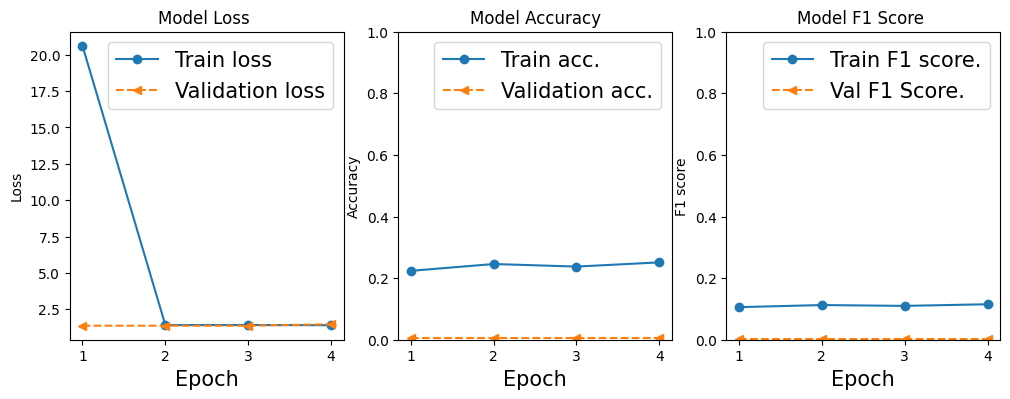

final train acc: 0.251
final val acc:   0.005

Unable to calculate percent diff as Train accuracy is zero
test_label length :  17138
predicted_labels length :  17138
confusion matrix shape= (4, 4)


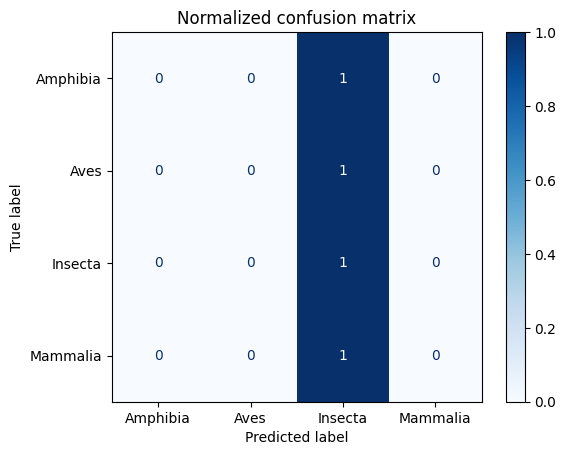

              precision    recall  f1-score   support

    Amphibia       0.00      0.00      0.00       350
        Aves       0.00      0.00      0.00     16588
     Insecta       0.01      1.00      0.01        93
    Mammalia       0.00      0.00      0.00       107

    accuracy                           0.01     17138
   macro avg       0.00      0.25      0.00     17138
weighted avg       0.00      0.01      0.00     17138



In [41]:
class_model_2_func = build_functional_model_2(X_common_train.shape[1],y_class_train.shape[1])

# train model on (X_train, y_train) data
history = class_model_2_func.fit(
    X_common_train,
    y_class_train,
    validation_data=(X_common_val,y_class_val),
    callbacks=[early_stopping_f1, reduce_lr_f1],
    class_weight=class_weights_dict,
    epochs=20)

# plot loss curves
show_history(history)

#plot confusion matrix
plot_confusion_matrix(class_model_2_func, X_common_train, y_class_train)


### Model 3

Model: "BirdClef"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 64, 64, 16)     │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 32, 32, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 16, 16, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 8, 8, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ taxonomy_class (Dense)          │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 180,724 (705.95 KB)

 Trainable params: 180,724 (705.95 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.2912 - f1_score: 0.1223 - loss: 2604.4680 - val_accuracy: 0.0054 - val_f1_score: 0.0027 - val_loss: 1.3728 - learning_rate: 0.1000
Epoch 2/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3329 - f1_score: 0.1333 - loss: 1.3361 - val_accuracy: 0.0054 - val_f1_score: 0.0027 - val_loss: 1.3685 - learning_rate: 0.1000
Epoch 3/20
529/536 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3416 - f1_score: 0.1355 - loss: 1.3352
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.05000000074505806.
536/536 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3402 - f1_score: 0.1352 - loss: 1.3365 - val_accuracy: 0.0054 - val_f1_score: 0.0027 - val_loss: 1.3673 - learning_rate: 0.1000
Epoch 4/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3744 - f1_score: 0.1432 - loss: 1.3240 - val_accuracy: 0.0054 - val_f1_score: 0.0027 - val_loss: 1.4697 - learning_rate: 0.0500
Epoch 4: early stopping
Restoring model weight

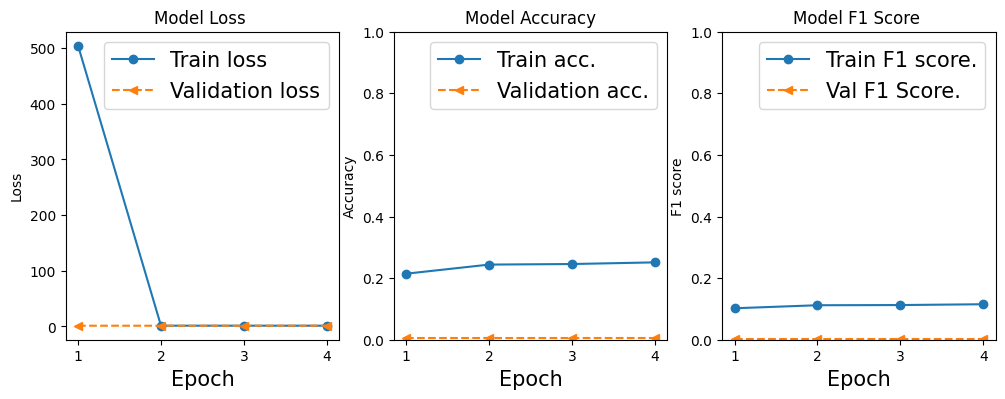

final train acc: 0.251
final val acc:   0.005

Unable to calculate percent diff as Train accuracy is zero
test_label length :  17138
predicted_labels length :  17138
confusion matrix shape= (4, 4)


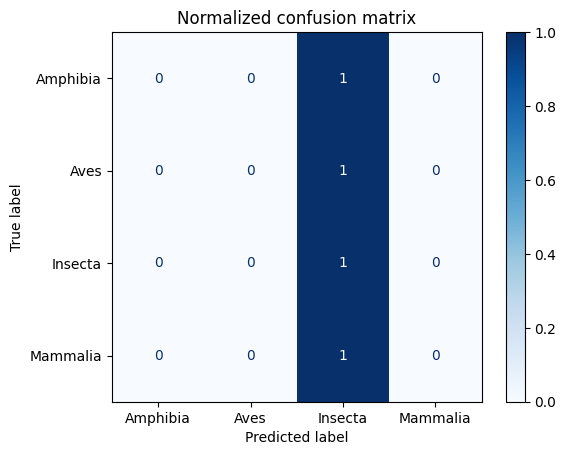

              precision    recall  f1-score   support

    Amphibia       0.00      0.00      0.00       350
        Aves       0.00      0.00      0.00     16588
     Insecta       0.01      1.00      0.01        93
    Mammalia       0.00      0.00      0.00       107

    accuracy                           0.01     17138
   macro avg       0.00      0.25      0.00     17138
weighted avg       0.00      0.01      0.00     17138



In [42]:
class_model_3_func = build_functional_model_3(X_common_train.shape[1],y_class_train.shape[1])

# train model on (X_train, y_train) data
history = class_model_3_func.fit(
    X_common_train,
    y_class_train,
    validation_data=(X_common_val,y_class_val),
    callbacks=[early_stopping_f1, reduce_lr_f1],
    class_weight=class_weights_dict,
    epochs=20)

# plot loss curves
show_history(history)

#plot confusion matrix
plot_confusion_matrix(class_model_3_func, X_common_train, y_class_train)

### Model 4

Model: "BirdClef"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 64, 64, 8)      │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 32, 32, 16)     │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 16, 16, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 8, 8, 64)       │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5 (Conv2D)                 │ (None, 4, 4, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_6 (Conv2D)                 │ (None, 2, 2, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ taxonomy_class (Dense)          │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 700,028 (2.67 MB)

 Trainable params: 700,028 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.0776 - f1_score: 0.1237 - loss: 7716.2417 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0027 - val_loss: 1.3824 - learning_rate: 0.1000
Epoch 2/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.0000e+00 - f1_score: 0.1345 - loss: 1.3344 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0027 - val_loss: 1.3717 - learning_rate: 0.1000
Epoch 3/20
525/536 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - f1_score: 0.1352 - loss: 1.3338
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.05000000074505806.
536/536 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.0000e+00 - f1_score: 0.1347 - loss: 1.3357 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0027 - val_loss: 1.3687 - learning_rate: 0.1000
Epoch 4/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.0000e+00 - f1_score: 0.1386 - loss: 1.3238 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0027 - val_loss: 1.4718 - learning_rate: 0.0500
Epoch 4: early

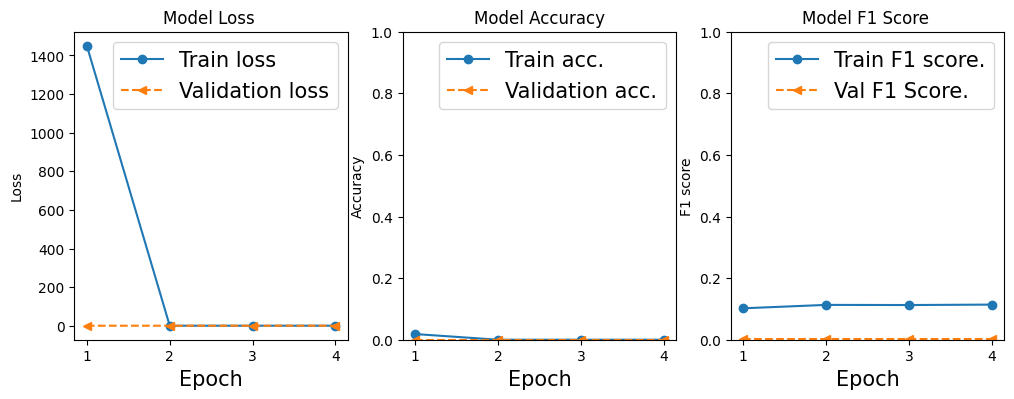

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  17138
predicted_labels length :  17138
confusion matrix shape= (4, 4)


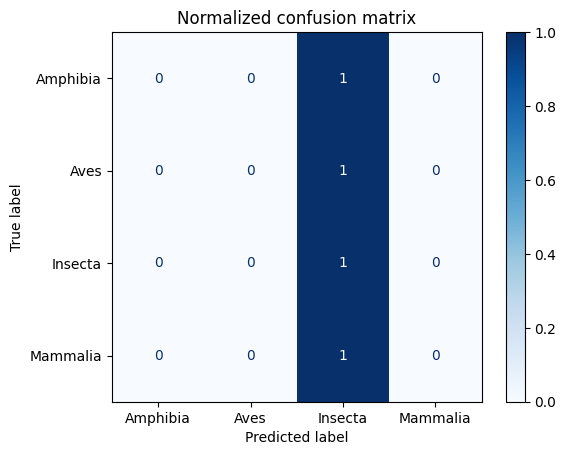

              precision    recall  f1-score   support

    Amphibia       0.00      0.00      0.00       350
        Aves       0.00      0.00      0.00     16588
     Insecta       0.01      1.00      0.01        93
    Mammalia       0.00      0.00      0.00       107

    accuracy                           0.01     17138
   macro avg       0.00      0.25      0.00     17138
weighted avg       0.00      0.01      0.00     17138



In [43]:
class_model_4_func = build_functional_model_4(X_common_train.shape[1],y_class_train.shape[1])

# train model on (X_train, y_train) data
history = class_model_4_func.fit(
    X_common_train,
    y_class_train,
    validation_data=(X_common_val,y_class_val),
    callbacks=[early_stopping_f1, reduce_lr_f1],
    class_weight=class_weights_dict,
    batch_size=32,
    epochs=20)

# plot loss curves
show_history(history)

#plot confusion matrix
plot_confusion_matrix(class_model_4_func, X_common_train, y_class_train)

### Summary of Models run so far


|Class weights|Model|# Conv|Filters|Stride|Kernel|MaxPool|Dropout|L.R.|Optimizer|Batch|Macro Precision|Macro Recall|Macro F1|Accuracy|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|Yes|1|1|64|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.00|0.25|0.00|0.01|
|Yes|2|2|(32,64)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.00|0.25|0.00|0.01|
|Yes|3|4|(16,32,64,128)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.00|0.25|0.00|0.01|
|Yes|4|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.00|0.25|0.00|0.01|


## Data Augmentation

To address the highly unbalanced class labels, we will attempt augmentation using Over Sampling and underSampling to balance the classes.

In [44]:
def add_smote_augmentation(train_data, train_label):
        print("Before augmentation: X shape:", train_data.shape)
        print("Before augmentation: y shape:", train_label.shape)

        #SMOTE expects 1D or 2D array at most. So need to reshape our 4D array
        original_shape = train_data.shape
        train_data = train_data.reshape(train_data.shape[0], train_data.shape[1]*train_data.shape[2]*train_data.shape[3])
        print("Reshaped train data : ",train_data.shape )

        X_resampled, y_resampled = SMOTE().fit_resample(train_data, train_label)

        print("After augmentation: X shape:", X_resampled.shape)
        print("After augmentation: y shape:", y_resampled.shape)

        #Rebuild our 4D data array
        X_resampled = X_resampled.reshape(X_resampled.shape[0], original_shape[1], original_shape[2], original_shape[3])
        print("Reshaped X_resampled : ",X_resampled.shape )

        return X_resampled, y_resampled

In [45]:
def add_adasyn_augmentation(train_data, train_label):
        print("Before augmentation: X shape:", train_data.shape)
        print("Before augmentation: y shape:", train_label.shape)

        #ADASYN expects 1D or 2D array at most. So need to reshape our 4D array
        original_shape = train_data.shape
        train_data = train_data.reshape(train_data.shape[0], train_data.shape[1]*train_data.shape[2]*train_data.shape[3])
        print("Reshaped train data : ",train_data.shape )

        X_resampled, y_resampled = ADASYN().fit_resample(train_data, train_label)
        #print(sorted(Counter(y_resampled).items()))


        print("After augmentation: X shape:", X_resampled.shape)
        print("After augmentation: y shape:", y_resampled.shape)

        #Rebuild our 4D data array
        X_resampled = X_resampled.reshape(X_resampled.shape[0], original_shape[1], original_shape[2], original_shape[3])
        print("Reshaped X_resampled : ",X_resampled.shape )

        return X_resampled, y_resampled

In [46]:
def create_undersampled_data(train_data, train_label, undersampl_type=1):
        print("Before augmentation: X shape:", train_data.shape)
        print("Before augmentation: y shape:", train_label.shape)

        #undersample expects 1D or 2D array at most. So need to reshape our 4D array
        original_shape = train_data.shape
        train_data = train_data.reshape(train_data.shape[0], train_data.shape[1]*train_data.shape[2]*train_data.shape[3])
        print("Reshaped train data : ",train_data.shape )

        # define the undersampling method
        #undersample = CondensedNearestNeighbour(n_neighbors=1)
        if undersampl_type == 1:
            undersample = NearMiss( version=3, n_neighbors_ver3=3)
        elif undersampl_type == 2:
            undersample = CondensedNearestNeighbour( n_neighbors=1)

        # transform the dataset
        X_undersampled, y_undersampled = undersample.fit_resample(train_data, train_label)
        #print(sorted(Counter(y_resampled).items()))

        print("After augmentation: X shape:", X_undersampled.shape)
        print("After augmentation: y shape:", y_undersampled.shape)

        #Rebuild our 4D data array
        X_undersampled = X_undersampled.reshape(X_undersampled.shape[0],
                                                original_shape[1],
                                                original_shape[2],
                                                original_shape[3])
        print("Reshaped X_undersampled : ",X_undersampled.shape )

        return X_undersampled, y_undersampled

In [47]:
def add_basic_augmentation(train_data, train_label, bright_delta, contrast_factor):
        print("Before augmentation: X shape:", train_data.shape)
        print("Before augmentation: y shape:", train_label.shape)

        # adjust brightness
        X_augm =  tf.image.adjust_brightness(train_data, delta=bright_delta)
        # adjust contrast
        X_augm = tf.image.adjust_contrast(X_augm, contrast_factor=contrast_factor)

        # concatenate original X and augmented X_aug data
        X = tf.concat([train_data, X_augm], axis=0)

        # concatenate y_train (note the label is preserved)
        y_augm = train_label
        y = tf.concat([train_label, y_augm],axis=0)
        print("After augmentation: X shape:", X.shape)
        print("After augmentation: y shape:", y.shape)

        return X, y

### OverSampling using SMOTE

Before augmentation: X shape: (17138, 64, 64, 1)
Before augmentation: y shape: (17138, 4)
Reshaped train data :  (17138, 4096)
After augmentation: X shape: (66352, 4096)
After augmentation: y shape: (66352, 4)
Reshaped X_resampled :  (66352, 64, 64, 1)


Model: "BirdClef"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 64, 64, 8)      │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 32, 32, 16)     │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 16, 16, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 8, 8, 64)       │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5 (Conv2D)                 │ (None, 4, 4, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_6 (Conv2D)                 │ (None, 2, 2, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ taxonomy_class (Dense)          │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 700,028 (2.67 MB)

 Trainable params: 700,028 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
2074/2074 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.0024 - f1_score: 0.2497 - loss: 76.1928 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0031 - val_loss: 1.5123 - learning_rate: 0.1000
Epoch 2/20
2074/2074 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.0000e+00 - f1_score: 0.2482 - loss: 1.3938 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0031 - val_loss: 1.5132 - learning_rate: 0.1000
Epoch 3/20
2071/2074 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - f1_score: 0.2482 - loss: 1.3938
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.05000000074505806.
2074/2074 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.0000e+00 - f1_score: 0.2482 - loss: 1.3938 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0031 - val_loss: 1.5133 - learning_rate: 0.1000
Epoch 4/20
2074/2074 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.0000e+00 - f1_score: 0.2429 - loss: 1.3903 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0027 - val_loss: 1.3844 - learning_rate: 0.0500
Epoch 4

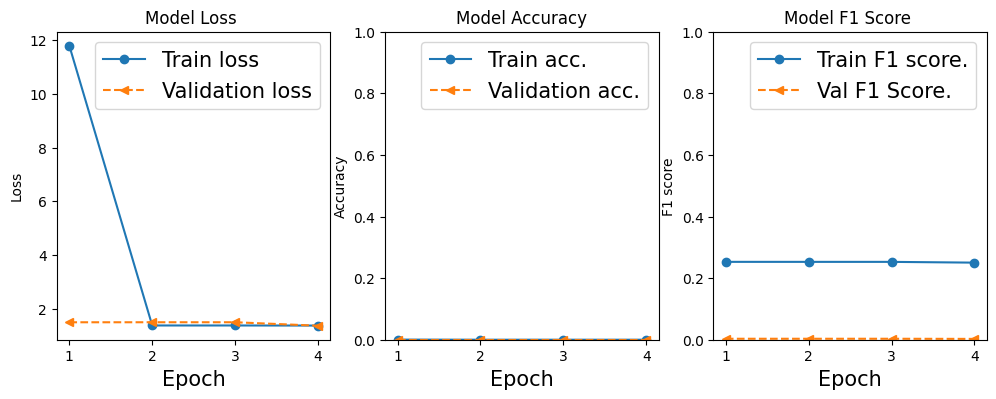

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  66352
predicted_labels length :  66352
confusion matrix shape= (4, 4)


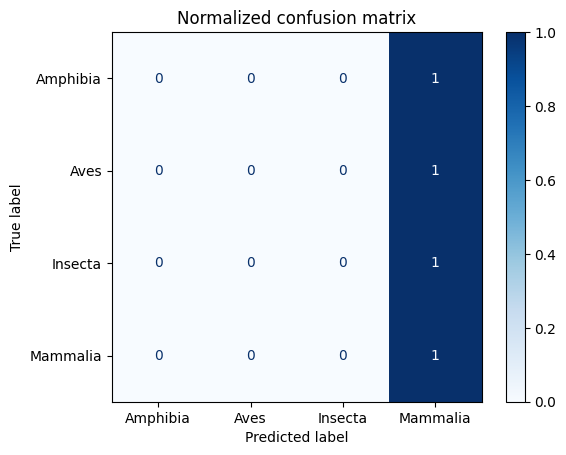

              precision    recall  f1-score   support

    Amphibia       0.00      0.00      0.00     16588
        Aves       0.00      0.00      0.00     16588
     Insecta       0.00      0.00      0.00     16588
    Mammalia       0.25      1.00      0.40     16588

    accuracy                           0.25     66352
   macro avg       0.06      0.25      0.10     66352
weighted avg       0.06      0.25      0.10     66352



In [48]:
#Augment Non-Majority class data with over-sampling

x_smote, y_smote = add_smote_augmentation(X_common_train, y_class_train)

# Rerun Model 4 with augmented data

class_model_4_augm = build_functional_model_4(x_smote.shape[1],y_smote.shape[1])

# train model on (x_smote, y_smote) data
history = class_model_4_augm.fit(
    x_smote,
    y_smote,
    validation_data=(X_common_val,y_class_val),
    callbacks=[early_stopping_acc, reduce_lr_acc],
    epochs=20)

# plot loss curves
show_history(history)

# plot confusion matrix
plot_confusion_matrix(class_model_4_augm, x_smote, y_smote)


### OverSampling using ADASYN

Before augmentation: X shape: (17138, 64, 64, 1)
Before augmentation: y shape: (17138, 4)
Reshaped train data :  (17138, 4096)
After augmentation: X shape: (66383, 4096)
After augmentation: y shape: (66383, 4)
Reshaped X_resampled :  (66383, 64, 64, 1)


Model: "BirdClef"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 64, 64, 8)      │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 32, 32, 16)     │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 16, 16, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 8, 8, 64)       │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5 (Conv2D)                 │ (None, 4, 4, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_6 (Conv2D)                 │ (None, 2, 2, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ taxonomy_class (Dense)          │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 700,028 (2.67 MB)

 Trainable params: 700,028 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.0022 - f1_score: 0.2447 - loss: 626.8303 - val_accuracy: 0.0000e+00 - val_f1_score: 0.2459 - val_loss: 1.1930 - learning_rate: 0.1000
Epoch 2/20
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.0000e+00 - f1_score: 0.2446 - loss: 1.3934 - val_accuracy: 0.0000e+00 - val_f1_score: 0.2459 - val_loss: 1.1932 - learning_rate: 0.1000
Epoch 3/20
2067/2075 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - f1_score: 0.2446 - loss: 1.3934
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.05000000074505806.
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.0000e+00 - f1_score: 0.2446 - loss: 1.3934 - val_accuracy: 0.0000e+00 - val_f1_score: 0.2459 - val_loss: 1.1932 - learning_rate: 0.1000
Epoch 4/20
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.0000e+00 - f1_score: 0.2420 - loss: 1.3901 - val_accuracy: 0.0000e+00 - val_f1_score: 0.2459 - val_loss: 1.2548 - learning_rate: 0.0500
Epoch 

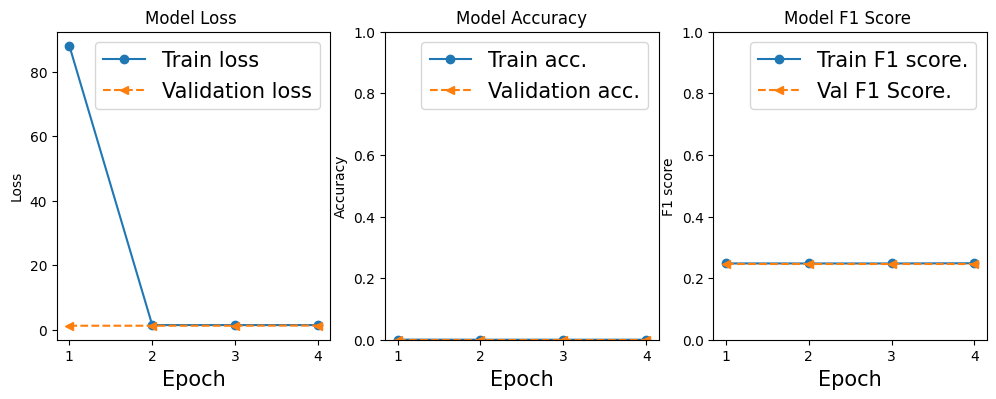

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  66383
predicted_labels length :  66383
confusion matrix shape= (4, 4)


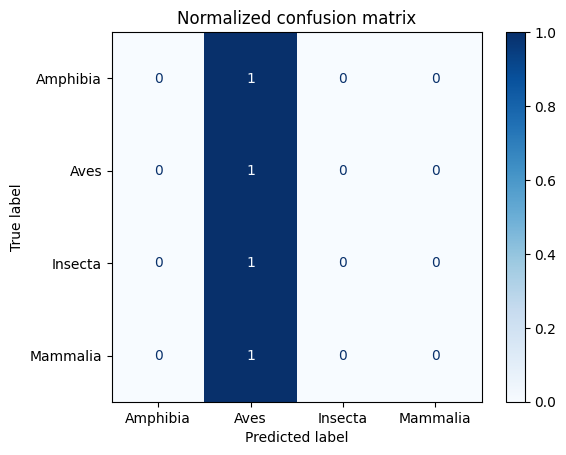

              precision    recall  f1-score   support

    Amphibia       0.00      0.00      0.00     16665
        Aves       0.25      1.00      0.40     16588
     Insecta       0.00      0.00      0.00     16593
    Mammalia       0.00      0.00      0.00     16537

    accuracy                           0.25     66383
   macro avg       0.06      0.25      0.10     66383
weighted avg       0.06      0.25      0.10     66383



In [49]:
#Augment Non-Majority class data with over-sampling

x_adasyn, y_adasyn = add_adasyn_augmentation(X_common_train, y_class_train)

# Rerun Model 4 with augmented data

class_model_4_augm = build_functional_model_4(x_adasyn.shape[1],y_adasyn.shape[1])

# train model on (x_adasyn, y_adasyn) data
history = class_model_4_augm.fit(
    x_adasyn,
    y_adasyn,
    validation_data=(X_common_val,y_class_val),
    callbacks=[early_stopping_acc, reduce_lr_acc],
    epochs=20)

# plot loss curves
show_history(history)

# plot confusion matrix
plot_confusion_matrix(class_model_4_augm, x_adasyn, y_adasyn)

### UnderSampling

Before augmentation: X shape: (17138, 64, 64, 1)
Before augmentation: y shape: (17138, 4)
Reshaped train data :  (17138, 4096)
After augmentation: X shape: (334, 4096)
After augmentation: y shape: (334, 4)
Reshaped X_undersampled :  (334, 64, 64, 1)


Model: "BirdClef"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 64, 64, 8)      │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 32, 32, 16)     │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 16, 16, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 8, 8, 64)       │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5 (Conv2D)                 │ (None, 4, 4, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_6 (Conv2D)                 │ (None, 2, 2, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ taxonomy_class (Dense)          │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 700,028 (2.67 MB)

 Trainable params: 700,028 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 680ms/step - accuracy: 0.1187 - f1_score: 0.2448 - loss: 6925.8110 - val_accuracy: 0.0000e+00 - val_f1_score: 0.2459 - val_loss: 1.2480 - learning_rate: 0.1000
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.0000e+00 - f1_score: 0.1576 - loss: 1.3720 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0027 - val_loss: 1.2477 - learning_rate: 0.1000
Epoch 3/20
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1_score: 0.1698 - loss: 1.3890 
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.05000000074505806.
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.0000e+00 - f1_score: 0.1670 - loss: 1.3861 - val_accuracy: 0.0000e+00 - val_f1_score: 0.2459 - val_loss: 1.2163 - learning_rate: 0.1000
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.0000e+00 - f1_score: 0.1172 - loss: 1.3794 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0100 - val_loss: 1.2693 - learning_rate: 0.0500
Epoch 4: early stop

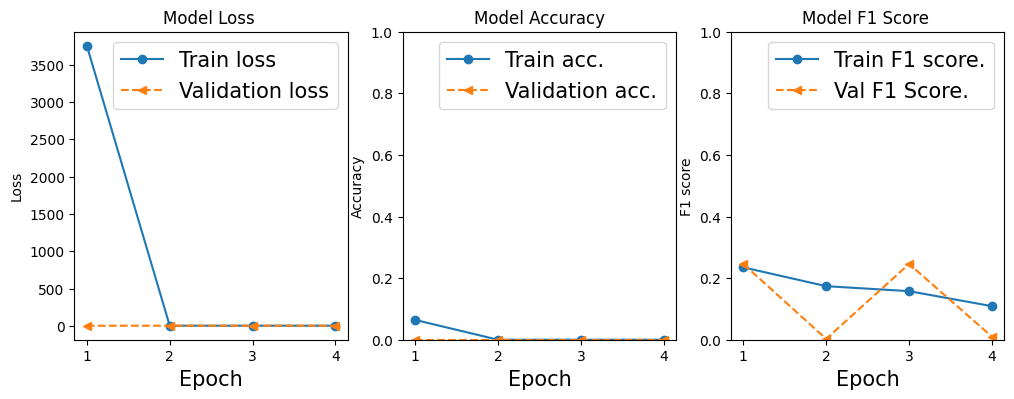

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  334
predicted_labels length :  334
confusion matrix shape= (4, 4)


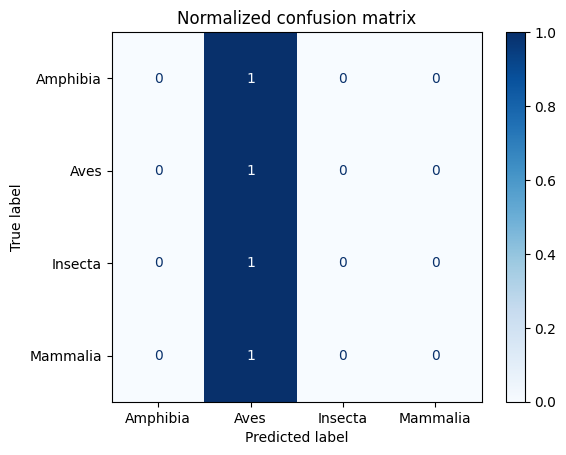

              precision    recall  f1-score   support

    Amphibia       0.00      0.00      0.00        93
        Aves       0.28      1.00      0.44        93
     Insecta       0.00      0.00      0.00        93
    Mammalia       0.00      0.00      0.00        55

    accuracy                           0.28       334
   macro avg       0.07      0.25      0.11       334
weighted avg       0.08      0.28      0.12       334



In [50]:
#Undersampling NearMiss


X_under_nearmiss, y_under_nearmiss = create_undersampled_data(X_common_train, y_class_train,undersampl_type=1)

# Rerun Model 4 with augmented data

class_model_4_augm = build_functional_model_4(X_under_nearmiss.shape[1],y_under_nearmiss.shape[1])

# train model on (X_train, y_train) data
history = class_model_4_augm.fit(
    X_under_nearmiss,
    y_under_nearmiss,
    validation_data=(X_common_val,y_class_val),
    callbacks=[early_stopping_acc, reduce_lr_acc],
    epochs=20)

# plot loss curves
show_history(history)

# plot confusion matrix
plot_confusion_matrix(class_model_4_augm, X_under_nearmiss, y_under_nearmiss)

Before augmentation: X shape: (17138, 64, 64, 1)
Before augmentation: y shape: (17138, 4)
Reshaped train data :  (17138, 4096)
After augmentation: X shape: (988, 4096)
After augmentation: y shape: (988, 4)
Reshaped X_undersampled :  (988, 64, 64, 1)


Model: "BirdClef"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 64, 64, 8)      │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 32, 32, 16)     │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 16, 16, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 8, 8, 64)       │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5 (Conv2D)                 │ (None, 4, 4, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_6 (Conv2D)                 │ (None, 2, 2, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ taxonomy_class (Dense)          │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 700,028 (2.67 MB)

 Trainable params: 700,028 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 242ms/step - accuracy: 0.0822 - f1_score: 0.2585 - loss: 887.2314 - val_accuracy: 0.0000e+00 - val_f1_score: 0.2459 - val_loss: 0.2901 - learning_rate: 0.1000
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0000e+00 - f1_score: 0.2071 - loss: 0.9302 - val_accuracy: 0.0000e+00 - val_f1_score: 0.2459 - val_loss: 0.3876 - learning_rate: 0.1000
Epoch 3/20
26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - f1_score: 0.2068 - loss: 0.9144
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.05000000074505806.
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0000e+00 - f1_score: 0.2071 - loss: 0.9115 - val_accuracy: 0.0000e+00 - val_f1_score: 0.2459 - val_loss: 0.3742 - learning_rate: 0.1000
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0000e+00 - f1_score: 0.2071 - loss: 0.9125 - val_accuracy: 0.0000e+00 - val_f1_score: 0.2459 - val_loss: 0.3870 - learning_rate: 0.0500
Epoch 4: early stoppi

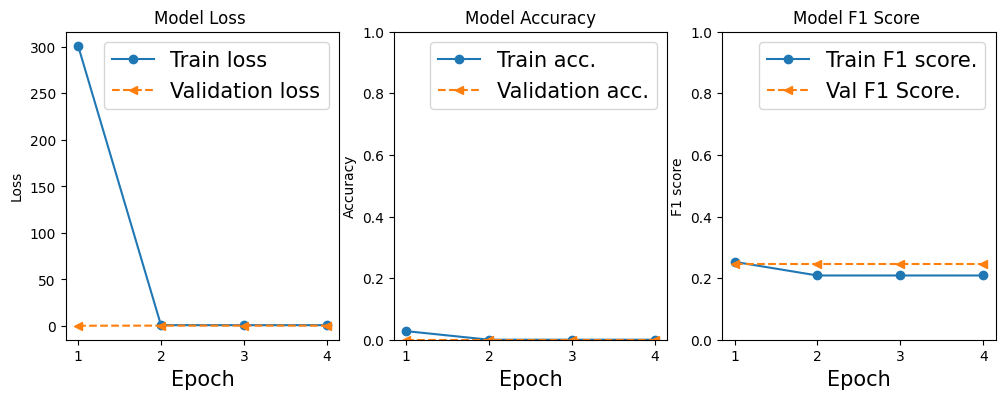

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  988
predicted_labels length :  988
confusion matrix shape= (4, 4)


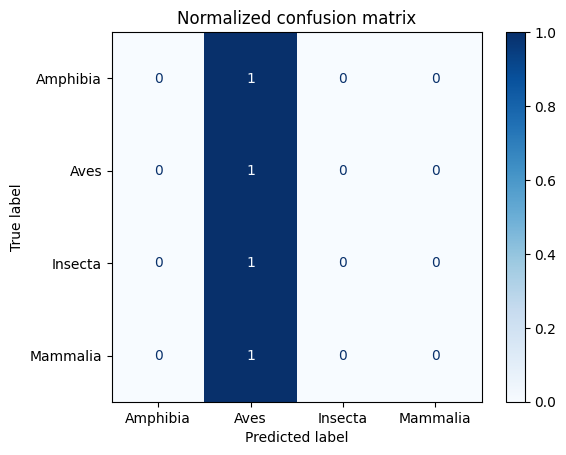

              precision    recall  f1-score   support

    Amphibia       0.00      0.00      0.00       134
        Aves       0.72      1.00      0.83       707
     Insecta       0.00      0.00      0.00        93
    Mammalia       0.00      0.00      0.00        54

    accuracy                           0.72       988
   macro avg       0.18      0.25      0.21       988
weighted avg       0.51      0.72      0.60       988



In [52]:
#Undersampling CNN


X_under_cnn, y_under_cnn = create_undersampled_data(X_common_train, y_class_train,undersampl_type=2)

# Rerun Model 4 with augmented data

class_model_4_augm = build_functional_model_4(X_under_cnn.shape[1],y_under_cnn.shape[1])

# train model on (X_train, y_train) data
history = class_model_4_augm.fit(
    X_under_cnn,
    y_under_cnn,
    validation_data=(X_common_val,y_class_val),
    callbacks=[early_stopping_acc, reduce_lr_acc],
    epochs=20)

# plot loss curves
show_history(history)

# plot confusion matrix
plot_confusion_matrix(class_model_4_augm, X_under_cnn, y_under_cnn)

Before augmentation: X shape: (17138, 64, 64, 1)
Before augmentation: y shape: (17138, 4)
Reshaped train data :  (17138, 4096)
After augmentation: X shape: (334, 4096)
After augmentation: y shape: (334, 4)
Reshaped X_undersampled :  (334, 64, 64, 1)
Before augmentation: X shape: (334, 64, 64, 1)
Before augmentation: y shape: (334, 4)
After augmentation: X shape: (668, 64, 64, 1)
After augmentation: y shape: (668, 4)


Model: "BirdClef"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 64, 64, 8)      │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 32, 32, 16)     │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 16, 16, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 8, 8, 64)       │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5 (Conv2D)                 │ (None, 4, 4, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_6 (Conv2D)                 │ (None, 2, 2, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ taxonomy_class (Dense)          │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 700,028 (2.67 MB)

 Trainable params: 700,028 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 299ms/step - accuracy: 0.0792 - f1_score: 0.1955 - loss: 1175.7872 - val_accuracy: 0.0000e+00 - val_f1_score: 0.2459 - val_loss: 1.1718 - learning_rate: 0.1000
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.0013 - f1_score: 0.1358 - loss: 2.5656 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0027 - val_loss: 1.2808 - learning_rate: 0.1000
Epoch 3/20
17/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1_score: 0.1256 - loss: 1.3643
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.05000000074505806.
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.0000e+00 - f1_score: 0.1397 - loss: 1.3658 - val_accuracy: 0.0000e+00 - val_f1_score: 0.2459 - val_loss: 1.2394 - learning_rate: 0.1000
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.0000e+00 - f1_score: 0.1186 - loss: 1.3673 - val_accuracy: 0.0000e+00 - val_f1_score: 0.2459 - val_loss: 1.2683 - learning_rate: 0.0500
Epoch 4: early stopping


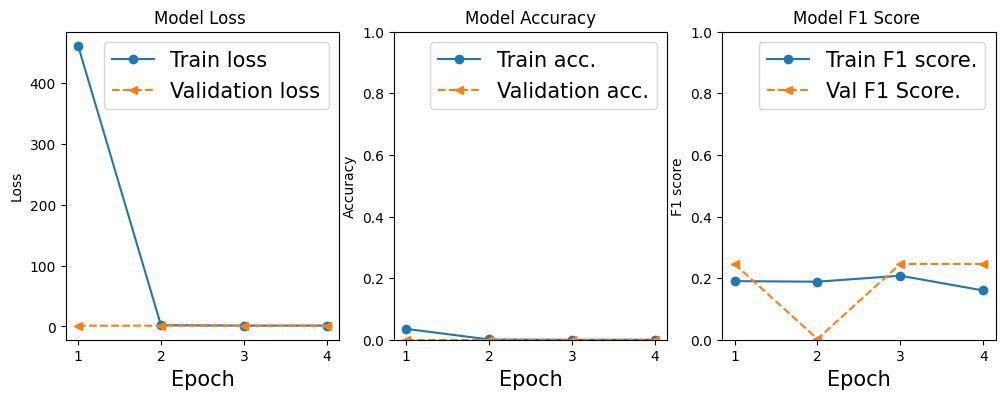

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  668
predicted_labels length :  668
confusion matrix shape= (4, 4)


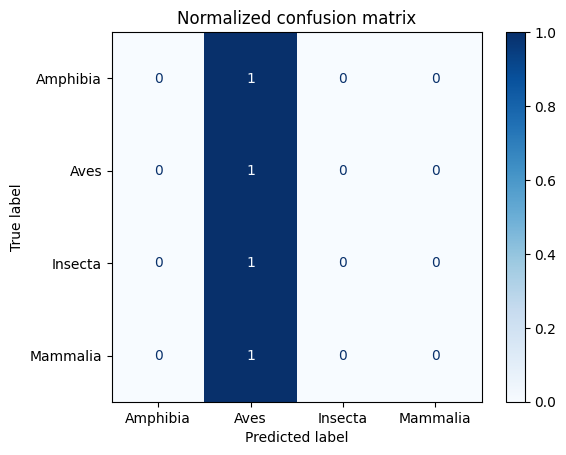

              precision    recall  f1-score   support

    Amphibia       0.00      0.00      0.00       186
        Aves       0.28      1.00      0.44       186
     Insecta       0.00      0.00      0.00       186
    Mammalia       0.00      0.00      0.00       110

    accuracy                           0.28       668
   macro avg       0.07      0.25      0.11       668
weighted avg       0.08      0.28      0.12       668



In [53]:
#Undersampling + Augmentation


X_undersampled, y_undersampled = create_undersampled_data(X_common_train, y_class_train,undersampl_type=1)

#augment undersampled data
bright_delta=0.1
contrast_factor=0.1
X_aug_under, y_aug_under = add_basic_augmentation(X_undersampled, y_undersampled, bright_delta, contrast_factor)

# run Model 4 with augmented undersampled data

class_model_4_augm_under = build_functional_model_4(X_aug_under.shape[1],
                                             y_aug_under.shape[1])

# train model
history = class_model_4_augm_under.fit(
    X_aug_under,
    y_aug_under,
    validation_data=(X_common_val,y_class_val),
    callbacks=[early_stopping_acc, reduce_lr_acc],
    epochs=20)

# plot loss curves
show_history(history)

# plot confusion matrix
plot_confusion_matrix(class_model_4_augm_under, X_aug_under, y_aug_under)

### Summary of Augmentation


|Class Wghts|Augm Type|Model|# Conv|Filters|Stride|Kernel|MaxPool|Dropout|L.R.|Optimizer|Batch|Macro Precision|Macro Recall|Macro F1|Accuracy|Prediction|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|No|Over-Smote|4|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.06|0.25|0.10|0.25|Mamalia|
|No|Over-Adasyn|4|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.06|0.25|0.10|0.25|Aves|
|No|Under-NearMiss|4|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.07|0.25|0.11|0.28|Aves|
|No|Under-CNN|4|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.18|0.25|0.21|0.71|Aves|
|No|Under-NearMiss-Augm|4|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.07|0.25|0.11|0.28|Aves|

##  Hypertuning Model Parmeters

So far, we have attempted the following:  
- different model depths,
- data oversampling,
- data undersampling,
- data augmentation

Next, we will attempt the following Hyperparameter tuning  using Model 4 with NearMiss UnderSampling as starting point.


|Augm Type|Model|# Conv|Filters|Stride|Kernel|MaxPool|Dropout|L.R.|Optimizer|Batch|Macro Prec.|Macro Recall|Macro F1|Accuracy|Prediction|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|Under-NearMiss|5|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32||||||
|Under-NearMiss|5|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|16||||||
|Under-NearMiss|5|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32||||||
|Under-NearMiss|5|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.1|RMSProp|32||||||
|Under-NearMiss|5|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.1|SGD|32||||||
|Under-NearMiss|5|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32||||||
|Under-NearMiss|5|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.01|Adam|32||||||
|Under-NearMiss|5|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.001|Adam|32||||||
|Under-NearMiss|5|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32||||||
|Under-NearMiss|5|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.4|0.1|Adam|32||||||
|Under-NearMiss|5|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.3|0.1|Adam|32||||||
|Under-NearMiss|5|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.2|0.1|Adam|32||||||


In [54]:
def build_model_tuning_model_5(img_size, output_size, **kwargs):
  """ Model_5 will be based on model 4 with configurable hyper parameters to aid tuninig
  """
  #set defaults
  maxpool=2
  learn_rate=0.1
  dropout=0.5
  optimizer='Adam'

  keys = kwargs.keys()
  for key in keys:
    if key == 'maxpool': maxpool=kwargs['maxpool']
    if key == 'learn_rate': learn_rate=kwargs['learn_rate']
    if key == 'dropout': dropout=kwargs['dropout']
    if key == 'optimizer': optimizer=kwargs['optimizer']


  tf.keras.backend.clear_session()
  tf.random.set_seed(1234)
  np.random.seed(1234)

  # build model
  image = tf.keras.layers.Input(shape=(img_size, img_size, 1), dtype=tf.float32, name='image')

  conv_1 = tf.keras.layers.Conv2D(filters=int(img_size/8),
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_1',
      activation='relu',
      kernel_regularizer=tf.keras.regularizers.L1L2)(image)
  maxpool_1 = tf.keras.layers.MaxPooling2D((maxpool,maxpool))(conv_1)
  dropout_1 = tf.keras.layers.Dropout(rate=dropout)(maxpool_1)

  # Add 2nd convolutional layer
  conv_2 = tf.keras.layers.Conv2D(filters= int(img_size/4),
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_2',
      activation='relu',
      kernel_regularizer=tf.keras.regularizers.L1L2)(dropout_1)
  maxpool_2 = tf.keras.layers.MaxPooling2D((maxpool,maxpool))(conv_2)
  dropout_2 = tf.keras.layers.Dropout(rate=dropout)(maxpool_2)

 # Add 3rd convolutional layer
  conv_3 = tf.keras.layers.Conv2D(filters= int(img_size/2),
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_3',
      activation='relu',
      kernel_regularizer=tf.keras.regularizers.L1L2)(dropout_2)
  maxpool_3 = tf.keras.layers.MaxPooling2D((maxpool,maxpool))(conv_3)
  dropout_3 = tf.keras.layers.Dropout(rate=dropout)(maxpool_3)

  # Add 4th convolutional layer
  conv_4 = tf.keras.layers.Conv2D(filters= img_size,
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_4',
      activation='relu',
      kernel_regularizer=tf.keras.regularizers.L1L2)(dropout_3)
  maxpool_4 = tf.keras.layers.MaxPooling2D((maxpool,maxpool))(conv_4)
  dropout_4 = tf.keras.layers.Dropout(rate=dropout)(maxpool_4)

  # Add 5th convolutional layer
  conv_5 = tf.keras.layers.Conv2D(filters= int(img_size*2),
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_5',
      activation='relu',
      kernel_regularizer=tf.keras.regularizers.L1L2)(dropout_4)
  maxpool_5 = tf.keras.layers.MaxPooling2D((maxpool,maxpool))(conv_5)
  dropout_5 = tf.keras.layers.Dropout(rate=dropout)(maxpool_5)


  # Add 6th convolutional layer
  conv_6 = tf.keras.layers.Conv2D(filters= int(img_size*4),
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_6',
      activation='relu',
      kernel_regularizer=tf.keras.regularizers.L1L2)(dropout_5)
  maxpool_6 = tf.keras.layers.MaxPooling2D((maxpool,maxpool))(conv_6)
  dropout_6 = tf.keras.layers.Dropout(rate=dropout)(maxpool_6)


  # Add a flattening layer
  flat_1 = tf.keras.layers.Flatten()(dropout_6)


  # Add classification layer
  taxonomy_class = tf.keras.layers.Dense(
      units=output_size, activation='softmax', name='taxonomy_class')(flat_1)

  model = tf.keras.Model(inputs=image,
                         outputs=taxonomy_class,
                         name='BirdClef')

  # compile model
  if optimizer == "Adam":
    opt = tf.keras.optimizers.Adam(learning_rate=learn_rate)
  elif optimizer == "RMSprop":
    opt = tf.keras.optimizers.RMSprop(learning_rate=learn_rate)
  elif optimizer == 'SGD':
    opt = tf.keras.optimizers.SGD(momentum=0.9, learning_rate=learn_rate)
  model.compile(
      optimizer=opt,
      loss=tf.keras.losses.CategoricalCrossentropy(),
       metrics=[tf.keras.metrics.Accuracy(),
               tf.keras.metrics.F1Score(average="macro")])


  # print model_tf summary
  #print(model.summary())
  return model

In [55]:
def evaluate_tuning_model_5(train_data,
                            label_data,
                            batch='default',
                            maxpool='default',
                            learn_rate='default',
                            dropout='default',
                            optimizer='default'):
  """ Build and Train model based on input parameters and display results
  """
  print(f"Running Tuning model with parameter values: " ,
          f" \nbatch={batch} \nmaxpool={maxpool} \nlearn_rate={learn_rate} \ndropout={dropout} \noptimizer={optimizer}"  )

  if maxpool != 'default':
    print("Tuning maxpool")
    model = build_model_tuning_model_5(train_data.shape[1],
                                     label_data.shape[1],
                                     maxpool=maxpool)
  elif learn_rate != 'default':
    print("Tuning learn_rate")
    model = build_model_tuning_model_5(train_data.shape[1],
                                     label_data.shape[1],
                                     learn_rate=learn_rate)
  elif dropout != 'default':
    print("Tuning dropout")
    model = build_model_tuning_model_5(train_data.shape[1],
                                     label_data.shape[1],
                                     dropout=dropout)
  elif optimizer != 'default':
    print("Tuning optimizer")
    model = build_model_tuning_model_5(train_data.shape[1],
                                     label_data.shape[1],
                                     optimizer=optimizer)
  else:
    print("Tuning Batch Size")
    model = build_model_tuning_model_5(train_data.shape[1],
                                     label_data.shape[1])

  # train model on (X_train, y_train) data
  if batch == 'default': batch = 32
  history = model.fit(
      train_data,
      label_data,
      validation_data=(X_common_val,y_class_val),
      callbacks=[early_stopping_acc, reduce_lr_acc],
      batch_size=batch,
      epochs=20)

  # plot loss curves
  show_history(history)

  #plot confusion matrix
  plot_confusion_matrix(model, train_data, label_data)
  return model

Running Tuning model with parameter values:   
batch=32 
maxpool=default 
learn_rate=default 
dropout=default 
optimizer=default
Tuning Batch Size
Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 569ms/step - accuracy: 0.1187 - f1_score: 0.2578 - loss: 6681.0723 - val_accuracy: 0.0000e+00 - val_f1_score: 0.2459 - val_loss: 1.1718 - learning_rate: 0.1000
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.0000e+00 - f1_score: 0.1239 - loss: 1.3710 - val_accuracy: 0.0000e+00 - val_f1_score: 0.2459 - val_loss: 1.2246 - learning_rate: 0.1000
Epoch 3/20
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1_score: 0.1781 - loss: 1.3865 
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.05000000074505806.
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.0000e+00 - f1_score: 0.1751 - loss: 1.3832 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0027 - val_loss: 1.2697 - learning_rate: 0.1000
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.0000e+00 - f1

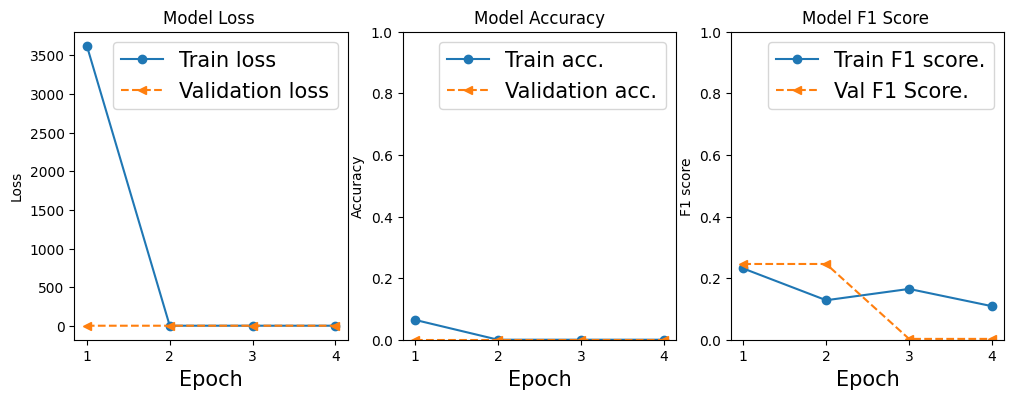

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  334
predicted_labels length :  334
confusion matrix shape= (4, 4)


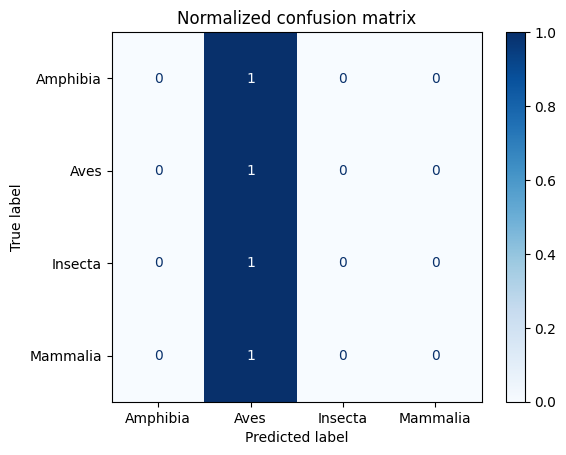

              precision    recall  f1-score   support

    Amphibia       0.00      0.00      0.00        93
        Aves       0.28      1.00      0.44        93
     Insecta       0.00      0.00      0.00        93
    Mammalia       0.00      0.00      0.00        55

    accuracy                           0.28       334
   macro avg       0.07      0.25      0.11       334
weighted avg       0.08      0.28      0.12       334

Running Tuning model with parameter values:   
batch=16 
maxpool=default 
learn_rate=default 
dropout=default 
optimizer=default
Tuning Batch Size
Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 324ms/step - accuracy: 0.0727 - f1_score: 0.1954 - loss: 212.7056 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0100 - val_loss: 1.4710 - learning_rate: 0.1000
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.0000e+00 - f1_score: 0.1434 - loss: 1.4027 - val_accuracy: 0.0000e+00 - val_f1_score: 0.2459 - val_loss: 1.2247 - learning_rate: 0.1000
Epoch 3/20
15/21

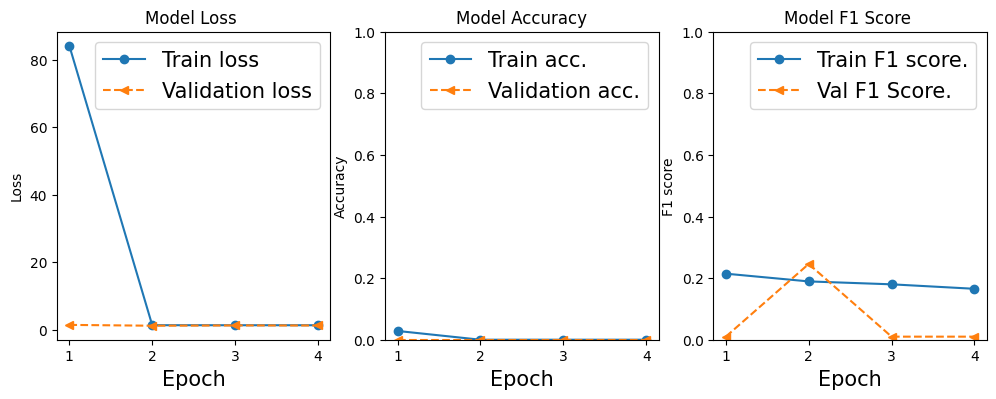

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  334
predicted_labels length :  334
confusion matrix shape= (4, 4)


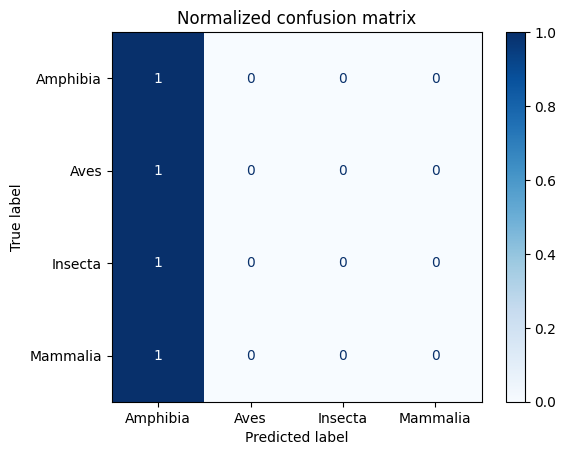

              precision    recall  f1-score   support

    Amphibia       0.28      1.00      0.44        93
        Aves       0.00      0.00      0.00        93
     Insecta       0.00      0.00      0.00        93
    Mammalia       0.00      0.00      0.00        55

    accuracy                           0.28       334
   macro avg       0.07      0.25      0.11       334
weighted avg       0.08      0.28      0.12       334

Running Tuning model with parameter values:   
batch=default 
maxpool=default 
learn_rate=default 
dropout=default 
optimizer=Adam
Tuning optimizer
Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 562ms/step - accuracy: 0.1187 - f1_score: 0.2439 - loss: 10107.8262 - val_accuracy: 0.0000e+00 - val_f1_score: 0.2459 - val_loss: 1.3106 - learning_rate: 0.1000
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.0000e+00 - f1_score: 0.1621 - loss: 1.3798 - val_accuracy: 0.0000e+00 - val_f1_score: 0.2459 - val_loss: 1.1607 - learning_rate: 0.1000
Epoch 3/20
 9

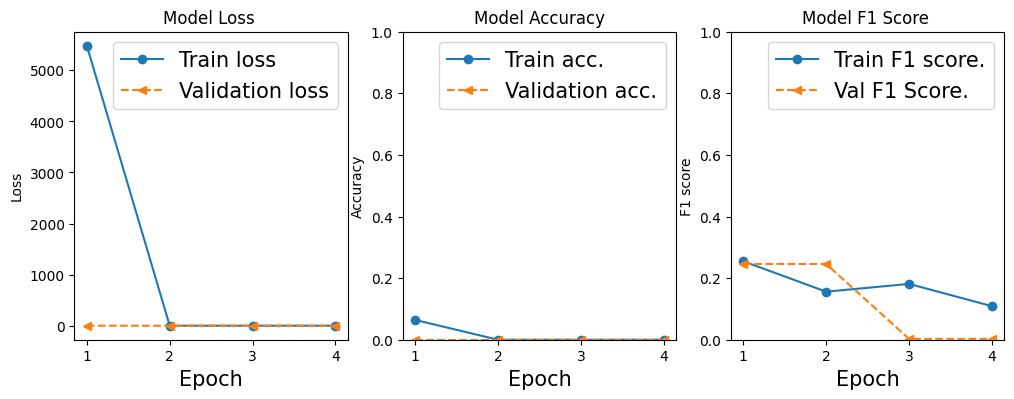

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  334
predicted_labels length :  334
confusion matrix shape= (4, 4)


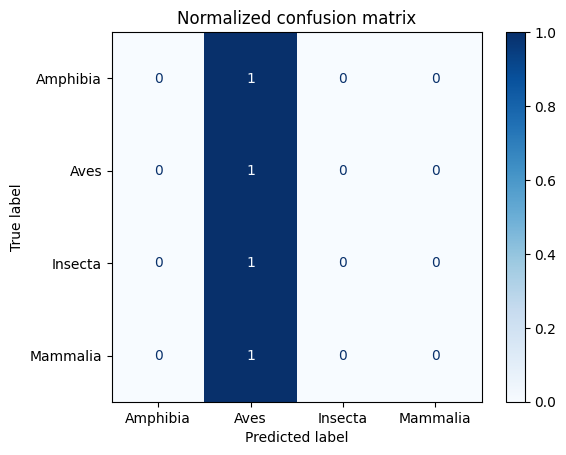

              precision    recall  f1-score   support

    Amphibia       0.00      0.00      0.00        93
        Aves       0.28      1.00      0.44        93
     Insecta       0.00      0.00      0.00        93
    Mammalia       0.00      0.00      0.00        55

    accuracy                           0.28       334
   macro avg       0.07      0.25      0.11       334
weighted avg       0.08      0.28      0.12       334

Running Tuning model with parameter values:   
batch=default 
maxpool=default 
learn_rate=default 
dropout=default 
optimizer=RMSprop
Tuning optimizer
Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 591ms/step - accuracy: 0.1669 - f1_score: 0.2131 - loss: 4898986.0000 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0027 - val_loss: 1.8273 - learning_rate: 0.1000
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.0000e+00 - f1_score: 0.1757 - loss: 1.4917 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0027 - val_loss: 1.6171 - learning_rate: 0.1000
Epoch 3/

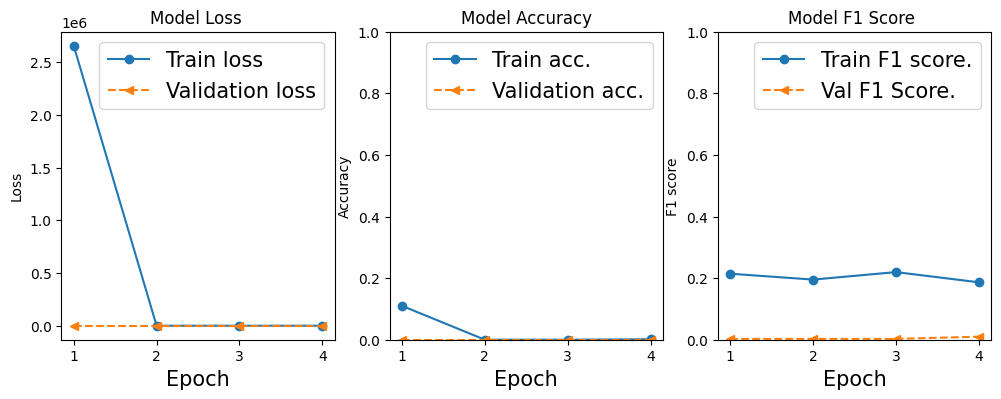

final train acc: 0.001
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  334
predicted_labels length :  334
confusion matrix shape= (4, 4)


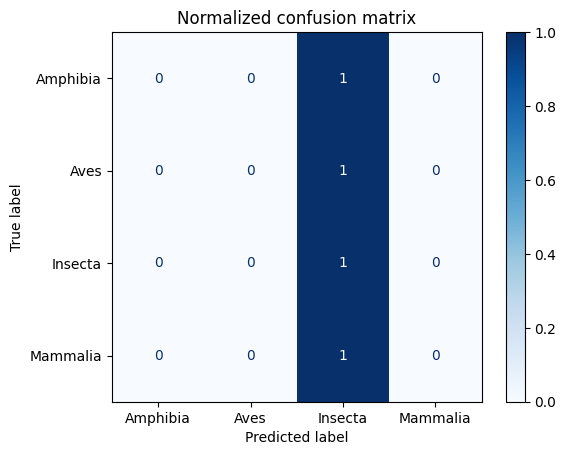

              precision    recall  f1-score   support

    Amphibia       0.00      0.00      0.00        93
        Aves       0.00      0.00      0.00        93
     Insecta       0.28      1.00      0.44        93
    Mammalia       0.00      0.00      0.00        55

    accuracy                           0.28       334
   macro avg       0.07      0.25      0.11       334
weighted avg       0.08      0.28      0.12       334

Running Tuning model with parameter values:   
batch=default 
maxpool=default 
learn_rate=default 
dropout=default 
optimizer=SGD
Tuning optimizer
Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 556ms/step - accuracy: 0.0000e+00 - f1_score: 0.2015 - loss: 1.3914 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0100 - val_loss: 1.3881 - learning_rate: 0.1000
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.0000e+00 - f1_score: 0.1708 - loss: 1.4009 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0027 - val_loss: 1.2910 - learning_rate: 0.1000
Epoch 3/20
 9/

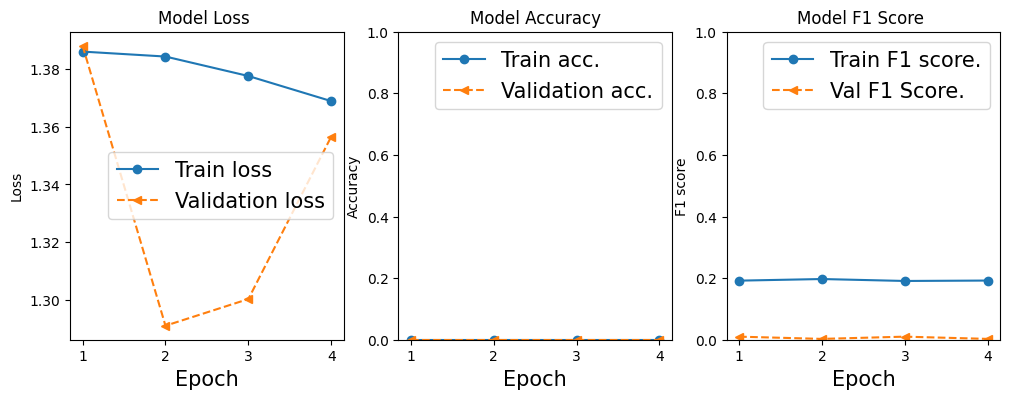

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  334
predicted_labels length :  334
confusion matrix shape= (4, 4)


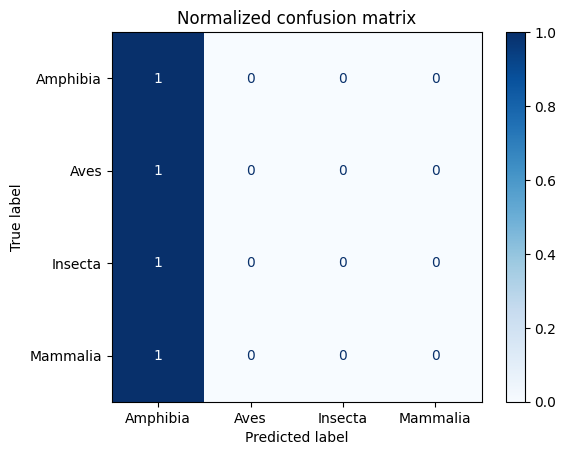

              precision    recall  f1-score   support

    Amphibia       0.28      1.00      0.44        93
        Aves       0.00      0.00      0.00        93
     Insecta       0.00      0.00      0.00        93
    Mammalia       0.00      0.00      0.00        55

    accuracy                           0.28       334
   macro avg       0.07      0.25      0.11       334
weighted avg       0.08      0.28      0.12       334

Running Tuning model with parameter values:   
batch=default 
maxpool=default 
learn_rate=0.1 
dropout=default 
optimizer=default
Tuning learn_rate
Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 552ms/step - accuracy: 0.1187 - f1_score: 0.2186 - loss: 710.7929 - val_accuracy: 0.0000e+00 - val_f1_score: 0.2459 - val_loss: 1.2697 - learning_rate: 0.1000
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.0000e+00 - f1_score: 0.1291 - loss: 1.5912 - val_accuracy: 0.0000e+00 - val_f1_score: 0.2459 - val_loss: 1.1558 - learning_rate: 0.1000
Epoch 3/20
 9/1

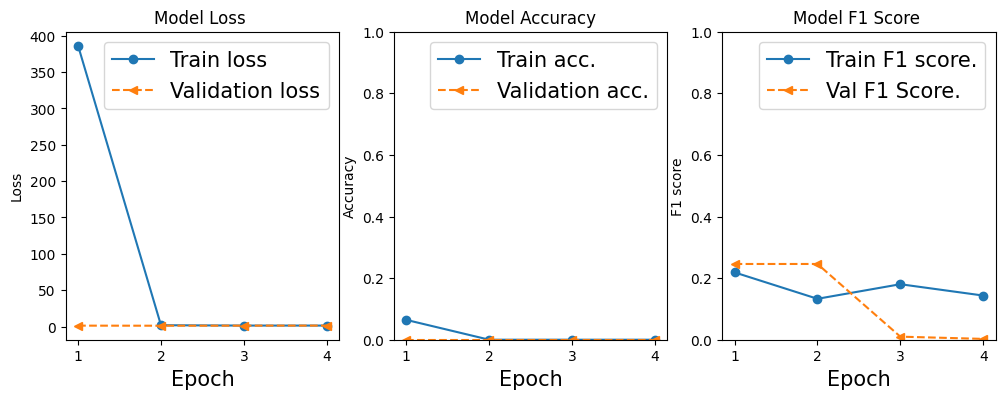

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  334
predicted_labels length :  334
confusion matrix shape= (4, 4)


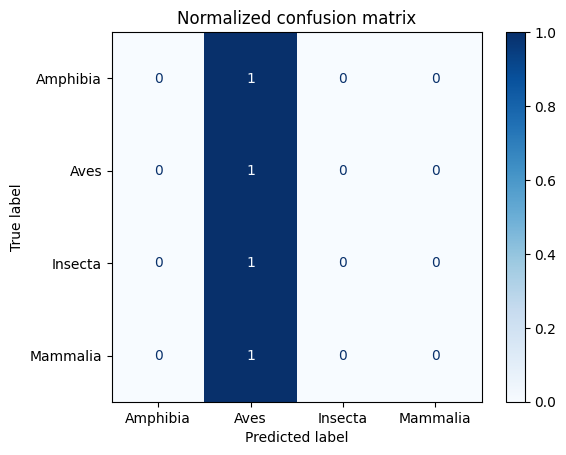

              precision    recall  f1-score   support

    Amphibia       0.00      0.00      0.00        93
        Aves       0.28      1.00      0.44        93
     Insecta       0.00      0.00      0.00        93
    Mammalia       0.00      0.00      0.00        55

    accuracy                           0.28       334
   macro avg       0.07      0.25      0.11       334
weighted avg       0.08      0.28      0.12       334

Running Tuning model with parameter values:   
batch=default 
maxpool=default 
learn_rate=0.01 
dropout=default 
optimizer=default
Tuning learn_rate
Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 556ms/step - accuracy: 0.0000e+00 - f1_score: 0.1830 - loss: 1.5074 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0027 - val_loss: 1.4236 - learning_rate: 0.0100
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.0000e+00 - f1_score: 0.1779 - loss: 1.3793 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0100 - val_loss: 1.3694 - learning_rate: 0.0100
Epoch 3/20
 

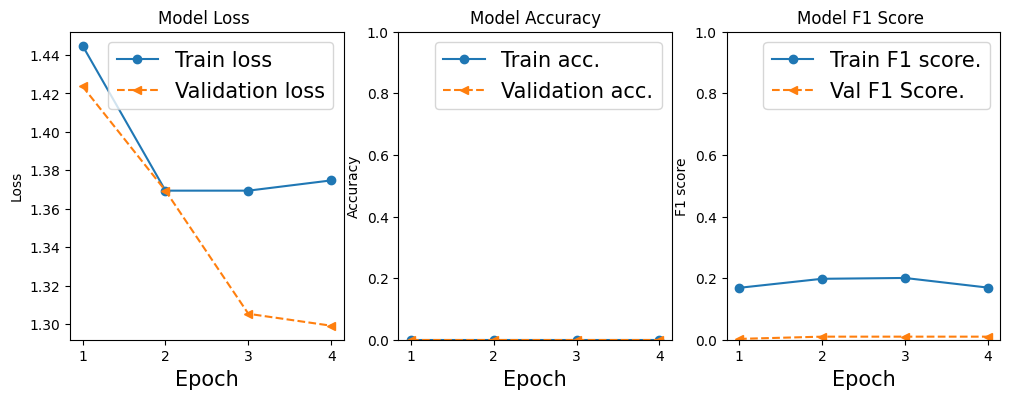

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  334
predicted_labels length :  334
confusion matrix shape= (4, 4)


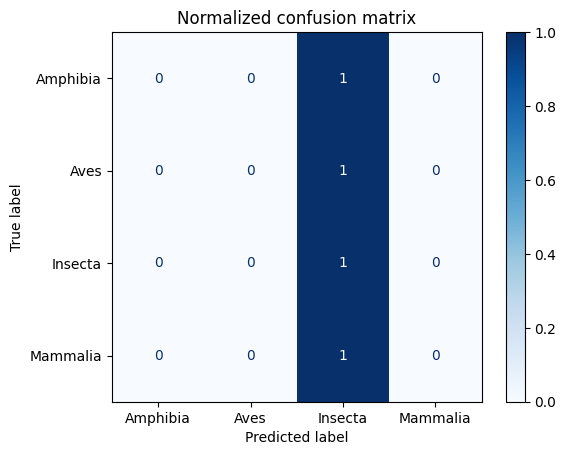

              precision    recall  f1-score   support

    Amphibia       0.00      0.00      0.00        93
        Aves       0.00      0.00      0.00        93
     Insecta       0.28      1.00      0.44        93
    Mammalia       0.00      0.00      0.00        55

    accuracy                           0.28       334
   macro avg       0.07      0.25      0.11       334
weighted avg       0.08      0.28      0.12       334

Running Tuning model with parameter values:   
batch=default 
maxpool=default 
learn_rate=0.001 
dropout=default 
optimizer=default
Tuning learn_rate
Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 559ms/step - accuracy: 0.0000e+00 - f1_score: 0.2505 - loss: 1.4342 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0100 - val_loss: 1.3797 - learning_rate: 0.0010
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.0000e+00 - f1_score: 0.1855 - loss: 1.4022 - val_accuracy: 0.0000e+00 - val_f1_score: 0.2459 - val_loss: 1.3685 - learning_rate: 0.0010
Epoch 3/20


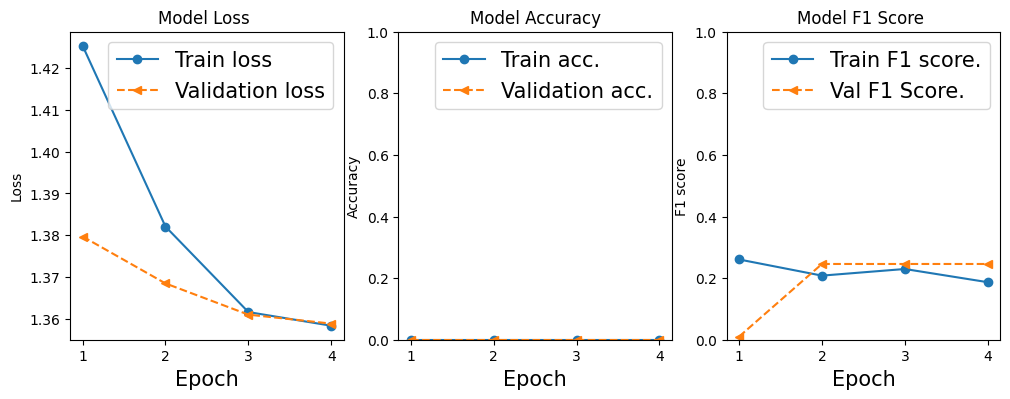

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  334
predicted_labels length :  334
confusion matrix shape= (4, 4)


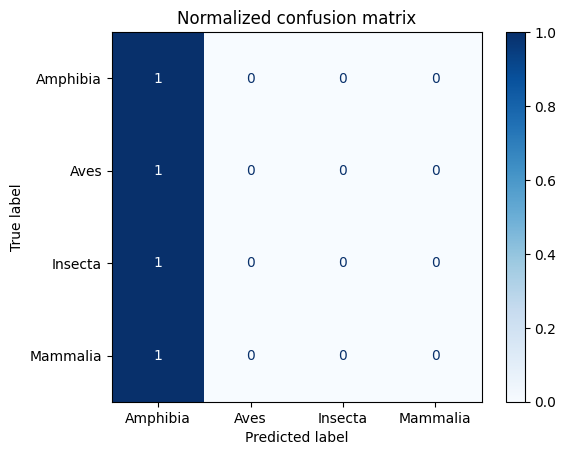

              precision    recall  f1-score   support

    Amphibia       0.28      1.00      0.44        93
        Aves       0.00      0.00      0.00        93
     Insecta       0.00      0.00      0.00        93
    Mammalia       0.00      0.00      0.00        55

    accuracy                           0.28       334
   macro avg       0.07      0.25      0.11       334
weighted avg       0.08      0.28      0.12       334

Running Tuning model with parameter values:   
batch=default 
maxpool=default 
learn_rate=default 
dropout=0.5 
optimizer=default
Tuning dropout
Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 569ms/step - accuracy: 0.1187 - f1_score: 0.2631 - loss: 50392.9414 - val_accuracy: 0.0000e+00 - val_f1_score: 0.2459 - val_loss: 1.2629 - learning_rate: 0.1000
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.0000e+00 - f1_score: 0.1667 - loss: 1.3750 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0027 - val_loss: 1.3817 - learning_rate: 0.1000
Epoch 3/20
 9/11

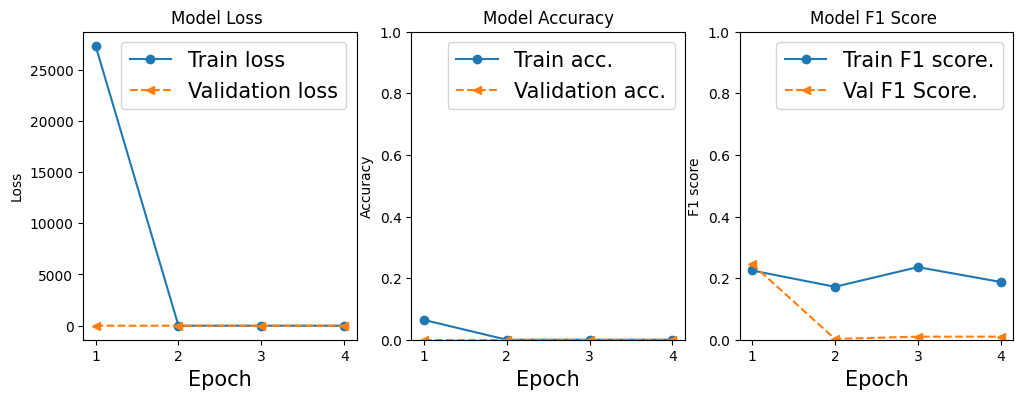

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  334
predicted_labels length :  334
confusion matrix shape= (4, 4)


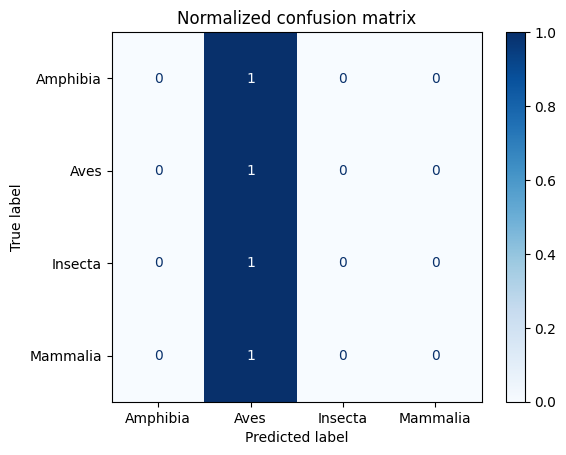

              precision    recall  f1-score   support

    Amphibia       0.00      0.00      0.00        93
        Aves       0.28      1.00      0.44        93
     Insecta       0.00      0.00      0.00        93
    Mammalia       0.00      0.00      0.00        55

    accuracy                           0.28       334
   macro avg       0.07      0.25      0.11       334
weighted avg       0.08      0.28      0.12       334

Running Tuning model with parameter values:   
batch=default 
maxpool=default 
learn_rate=default 
dropout=0.4 
optimizer=default
Tuning dropout
Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 626ms/step - accuracy: 0.1187 - f1_score: 0.2577 - loss: 754.5408 - val_accuracy: 0.0000e+00 - val_f1_score: 0.2459 - val_loss: 1.2731 - learning_rate: 0.1000
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.0000e+00 - f1_score: 0.1172 - loss: 1.3715 - val_accuracy: 1.3128e-04 - val_f1_score: 0.2502 - val_loss: 1.2168 - learning_rate: 0.1000
Epoch 3/20
11/11 ━

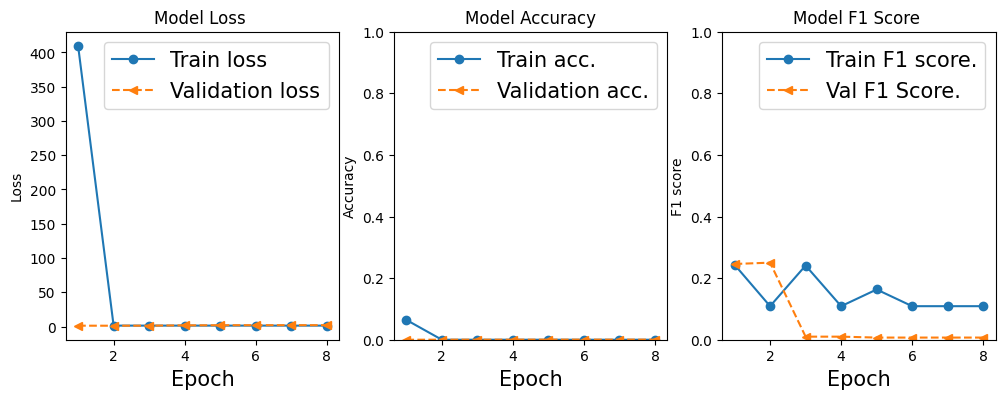

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  334
predicted_labels length :  334
confusion matrix shape= (4, 4)


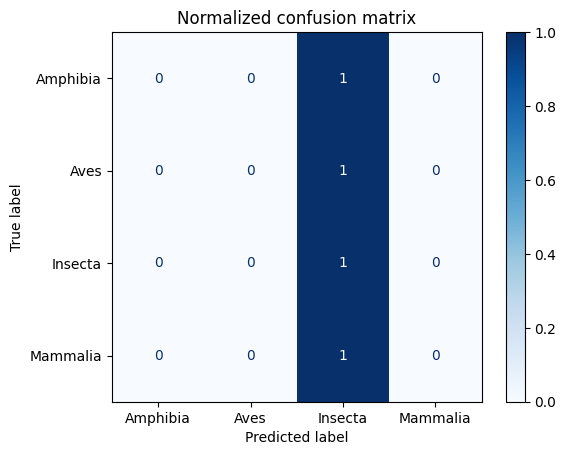

              precision    recall  f1-score   support

    Amphibia       0.00      0.00      0.00        93
        Aves       0.00      0.00      0.00        93
     Insecta       0.28      1.00      0.44        93
    Mammalia       0.00      0.00      0.00        55

    accuracy                           0.28       334
   macro avg       0.07      0.25      0.11       334
weighted avg       0.08      0.28      0.12       334

Running Tuning model with parameter values:   
batch=default 
maxpool=default 
learn_rate=default 
dropout=0.3 
optimizer=default
Tuning dropout
Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 613ms/step - accuracy: 0.1187 - f1_score: 0.2227 - loss: 45519.7656 - val_accuracy: 0.0000e+00 - val_f1_score: 0.2459 - val_loss: 1.2730 - learning_rate: 0.1000
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.0041 - f1_score: 0.1572 - loss: 19.7286 - val_accuracy: 0.0000e+00 - val_f1_score: 0.2459 - val_loss: 1.2185 - learning_rate: 0.1000
Epoch 3/20
 9/11 ━━

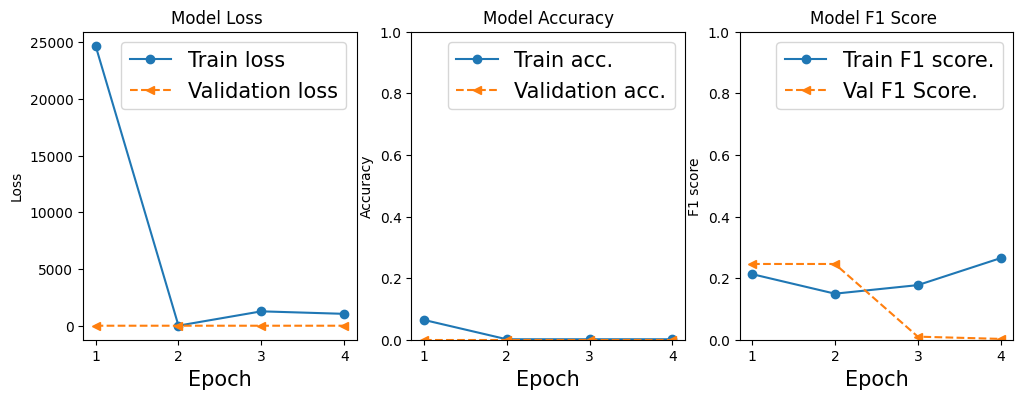

final train acc: 0.001
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  334
predicted_labels length :  334
confusion matrix shape= (4, 4)


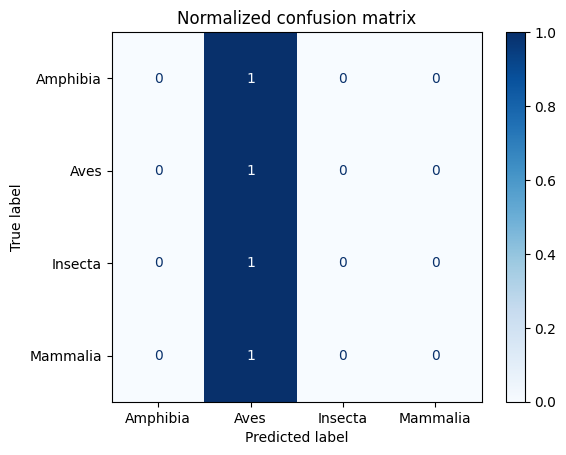

              precision    recall  f1-score   support

    Amphibia       0.00      0.00      0.00        93
        Aves       0.28      1.00      0.44        93
     Insecta       0.00      0.00      0.00        93
    Mammalia       0.00      0.00      0.00        55

    accuracy                           0.28       334
   macro avg       0.07      0.25      0.11       334
weighted avg       0.08      0.28      0.12       334

Running Tuning model with parameter values:   
batch=default 
maxpool=default 
learn_rate=default 
dropout=0.2 
optimizer=default
Tuning dropout
Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 614ms/step - accuracy: 0.1448 - f1_score: 0.2168 - loss: 76114.7500 - val_accuracy: 0.0080 - val_f1_score: 0.0100 - val_loss: 144.4376 - learning_rate: 0.1000
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.0857 - f1_score: 0.1869 - loss: 29.5269 - val_accuracy: 0.0000e+00 - val_f1_score: 0.2459 - val_loss: 0.8055 - learning_rate: 0.1000
Epoch 3/20
 9/11 ━━━━

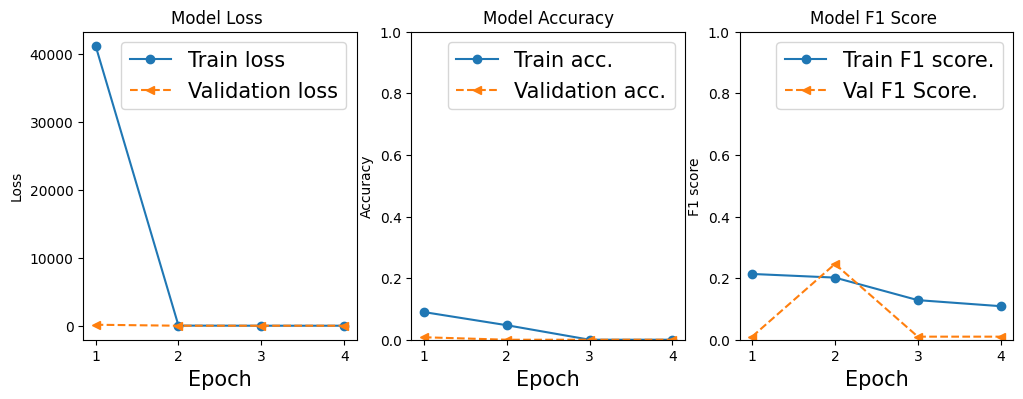

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  334
predicted_labels length :  334
confusion matrix shape= (4, 4)


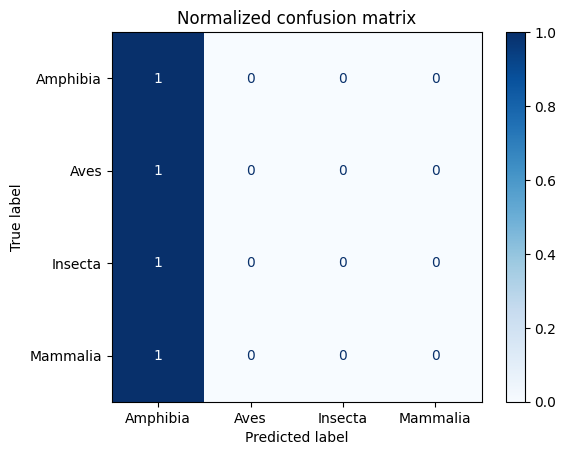

              precision    recall  f1-score   support

    Amphibia       0.28      1.00      0.44        93
        Aves       0.00      0.00      0.00        93
     Insecta       0.00      0.00      0.00        93
    Mammalia       0.00      0.00      0.00        55

    accuracy                           0.28       334
   macro avg       0.07      0.25      0.11       334
weighted avg       0.08      0.28      0.12       334



In [56]:
optimizer_list = ['Adam', 'RMSprop', "SGD"]
learn_rate_list = [0.1, 0.01, 0.001]
dropout_list = [0.5, 0.4, 0.3, 0.2]
maxpool_list = [2,4]
batch_size_list = [32, 16]

#Batch Size
for item in batch_size_list:
      evaluate_tuning_model_5(X_under_nearmiss, y_under_nearmiss, batch=item)
#Optimizer
for item in optimizer_list:
      evaluate_tuning_model_5(X_under_nearmiss, y_under_nearmiss, optimizer=item)

#Learn Rate
for item in learn_rate_list:
      evaluate_tuning_model_5(X_under_nearmiss, y_under_nearmiss, learn_rate=item)
#Dropout
for item in dropout_list:
      evaluate_tuning_model_5(X_under_nearmiss, y_under_nearmiss, dropout=item)
#Maxpool
#for item in maxpool_list:
 #     evaluate_tuning_model_5(X_under_nearmiss, y_under_nearmiss, maxpool=item)




#### Summary of HyperParameter Tuning


|Augm Type|Model|# Conv|Filters|Stride|kernel|MaxPool|Dropout|L.R.|Optimizer|batch|Macro Prec.|Macro Recall|Macro F1|Accuracy|Prediction|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|Under-NearMiss|5|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.07|0.25|0.11|0.28|Aves|
|Under-NearMiss|5|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|16|0.07|0.25|0.11|0.28|Amphibia|
|Under-NearMiss|5|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.07|0.25|0.11|0.28|Aves|
|Under-NearMiss|5|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.1|RMSProp|32|0.07|0.25|0.11|0.28|Insecta|
|Under-NearMiss|5|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.1|SGD|32|0.07|0.25|0.11|0.28|Amphibia|
|Under-NearMiss|5|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.07|0.25|0.11|0.28|Aves|
|Under-NearMiss|5|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.01|Adam|32|0.07|0.25|0.11|0.28|Insecta|
|Under-NearMiss|5|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.001|Adam|32|0.07|0.25|0.11|0.28|Amphibia|
|Under-NearMiss|5|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.07|0.25|0.11|0.28|Aves|
|Under-NearMiss|5|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.4|0.1|Adam|32|0.07|0.25|0.11|0.28|Insecta|
|Under-NearMiss|5|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.3|0.1|Adam|32|0.07|0.25|0.11|0.28|Aves|
|Under-NearMiss|5|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.2|0.1|Adam|32|0.07|0.25|0.11|0.28|Amphibia|

Based on the above data, Under Sampling using CNN appears to give the best performance. Reducing Dropout to 0.2 appears to improve performance as well. Batch Size, Learning Rate and Optimizer type did not appear to have significant impact on the performance.

## Model Evaluation

#### Summary of all Runs

|Class Weights|Augm Type|Model|# Conv|Filters|Stride|Kernel|MaxPool|Dropout|L.R.|Optimizer|Batch|Macro Precision|Macro Recall|Macro F1|Accuracy|Prediction|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|Yes||1|1|64|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.00|0.25|0.00|0.01|Insecta|
|Yes||2|2|(32,64)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.00|0.25|0.00|0.01|Insecta|
|Yes||3|4|(16,32,64,128)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.00|0.25|0.00|0.01|Insecta|
|Yes||4|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.00|0.25|0.00|0.01|Insecta|
|No|Over-Smote|4|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.06|0.25|0.10|0.25|Mammalia|
|No|Over-Adasyn|4|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.06|0.25|0.10|0.25|Aves|
|No|Under-NearMiss|4|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.07|0.25|0.11|0.28|Aves|
|No|Under-CNN|4|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.18|0.25|0.21|0.71|Aves|
|No|Under-NearMiss-Augm|4|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.07|0.25|0.11|0.28|Aves|
|No|Under-NearMiss|5|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.07|0.25|0.11|0.28|Aves|
|No|Under-NearMiss|5|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|16|0.07|0.25|0.11|0.28|Aves|
|No|Under-NearMiss|5|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.07|0.25|0.11|0.28|Insecta|
|No|Under-NearMiss|5|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.1|RMSProp|32|0.07|0.25|0.11|0.28|Insecta|
|No|Under-NearMiss|5|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.1|SGD|32|0.07|0.25|0.11|0.28|Amphibia|
|No|Under-NearMiss|5|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.07|0.25|0.11|0.28|Aves|
|No|Under-NearMiss|5|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.01|Adam|32|0.07|0.25|0.11|0.28|Insecta|
|No|Under-NearMiss|5|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.001|Adam|32|0.07|0.25|0.11|0.28|Amphibia|
|No|Under-NearMiss|5|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.07|0.25|0.11|0.28|Aves|
|No|Under-NearMiss|5|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.4|0.1|Adam|32|0.07|0.25|0.11|0.28|Aves|
|No|Under-NearMiss|5|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.3|0.1|Adam|32|0.07|0.25|0.11|0.28|Amphibia|
|No|Under-NearMiss|5|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.2|0.1|Adam|32|0.14|0.25|0.12|0.28|Aves + Amphibia|


Based on the results from the Tuning, we will select the following parameters for our evaluation with test data.

|Class Weights|Augm Type|Model|# Conv|Filters|Stride|Kernel|MaxPool|Dropout|L.R.|Optimizer|Batch|Macro Precision|Macro Recall|Macro F1|Accuracy|Prediction|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|No|Under-CNN|4|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.1|0.01|Adam|32||||||

In [58]:
def build_evaluation_model(img_size, output_size):
  """ Train model based on selected parameters and display results
  Using Model_4 which has 6 blocks of convolutional layer followed by MaxPool and Dropout
  """
  dropout = 0.1
  l_r = 0.01

  tf.keras.backend.clear_session()
  tf.random.set_seed(1234)
  np.random.seed(1234)

  # build model
  image = tf.keras.layers.Input(shape=(img_size, img_size, 1), dtype=tf.float32, name='image')

  conv_1 = tf.keras.layers.Conv2D(filters=int(img_size/8),
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_1',
      activation='relu',
      kernel_regularizer=tf.keras.regularizers.L1L2)(image)
  maxpool_1 = tf.keras.layers.MaxPooling2D((2,2))(conv_1)
  dropout_1 = tf.keras.layers.Dropout(rate=dropout)(maxpool_1)

  # Add 2nd convolutional layer
  conv_2 = tf.keras.layers.Conv2D(filters= int(img_size/4),
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_2',
      activation='relu',
      kernel_regularizer=tf.keras.regularizers.L1L2)(dropout_1)
  maxpool_2 = tf.keras.layers.MaxPooling2D((2,2))(conv_2)
  dropout_2 = tf.keras.layers.Dropout(rate=dropout)(maxpool_2)

 # Add 3rd convolutional layer
  conv_3 = tf.keras.layers.Conv2D(filters= int(img_size/2),
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_3',
      activation='relu',
      kernel_regularizer=tf.keras.regularizers.L1L2)(dropout_2)
  maxpool_3 = tf.keras.layers.MaxPooling2D((2,2))(conv_3)
  dropout_3 = tf.keras.layers.Dropout(rate=dropout)(maxpool_3)

  # Add 4th convolutional layer
  conv_4 = tf.keras.layers.Conv2D(filters= img_size,
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_4',
      activation='relu',
      kernel_regularizer=tf.keras.regularizers.L1L2)(dropout_3)
  maxpool_4 = tf.keras.layers.MaxPooling2D((2,2))(conv_4)
  dropout_4 = tf.keras.layers.Dropout(rate=dropout)(maxpool_4)

  # Add 5th convolutional layer
  conv_5 = tf.keras.layers.Conv2D(filters= int(img_size*2),
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_5',
      activation='relu',
      kernel_regularizer=tf.keras.regularizers.L1L2)(dropout_4)
  maxpool_5 = tf.keras.layers.MaxPooling2D((2,2))(conv_5)
  dropout_5 = tf.keras.layers.Dropout(rate=dropout)(maxpool_5)


  # Add 6th convolutional layer
  conv_6 = tf.keras.layers.Conv2D(filters= int(img_size*4),
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_6',
      activation='relu',
      kernel_regularizer=tf.keras.regularizers.L1L2)(dropout_5)
  maxpool_6 = tf.keras.layers.MaxPooling2D((2,2))(conv_6)
  dropout_6 = tf.keras.layers.Dropout(rate=dropout)(maxpool_6)


  # Add a flattening layer
  flat_1 = tf.keras.layers.Flatten()(dropout_6)


  # Add classification layer
  taxonomy_class = tf.keras.layers.Dense(
      units=output_size, activation='softmax', name='taxonomy_class')(flat_1)

  model = tf.keras.Model(inputs=image,
                         outputs=taxonomy_class,
                         name='BirdClef')

  # compile model
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=l_r),
      loss=tf.keras.losses.CategoricalCrossentropy(),
       metrics=[tf.keras.metrics.Accuracy(),
               tf.keras.metrics.F1Score(average="macro")])


  # print model_tf summary
  print(model.summary())
  return model



In [61]:
#Recalculate class weights due to class imbalance

#decode y_under_cnn
print("y_under_cnn shape: ", y_under_cnn.shape)
y_under_cnn_decoded = np.argmax(y_under_cnn, axis=1)
print("y_under_cnn_decoded shape: ", y_under_cnn_decoded.shape)
class_weights_list = compute_class_weight(
                                        class_weight='balanced',
                                        classes=unique_classes,
                                        y=y_under_cnn_decoded)

# Convert to a dictionary for Keras/TensorFlow
under_cnn_class_weights_dict = dict(zip(unique_classes,
                              class_weights_list))

under_cnn_class_weights_dict

y_under_cnn shape:  (988, 4)
y_under_cnn_decoded shape:  (988,)


{np.int64(0): np.float64(1.8432835820895523),
 np.int64(1): np.float64(0.3493635077793494),
 np.int64(2): np.float64(2.6559139784946235),
 np.int64(3): np.float64(4.574074074074074)}

Model: "BirdClef"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 64, 64, 8)      │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 32, 32, 16)     │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 16, 16, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 8, 8, 64)       │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5 (Conv2D)                 │ (None, 4, 4, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_6 (Conv2D)                 │ (None, 2, 2, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ taxonomy_class (Dense)          │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 700,028 (2.67 MB)

 Trainable params: 700,028 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - accuracy: 0.0022 - f1_score: 0.2098 - loss: 4.3593 - val_accuracy: 0.0000e+00 - val_f1_score: 0.2459 - val_loss: 1.3554 - learning_rate: 0.0100
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0000e+00 - f1_score: 0.1426 - loss: 1.4155 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0031 - val_loss: 1.3884 - learning_rate: 0.0100
Epoch 3/20
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - f1_score: 0.0786 - loss: 1.4139
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0000e+00 - f1_score: 0.0798 - loss: 1.4114 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0031 - val_loss: 1.3855 - learning_rate: 0.0100
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0000e+00 - f1_score: 0.1132 - loss: 1.4105 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0031 - val_loss: 1.3844 - learning_rate: 0.0050
Epoch 4: early stoppin

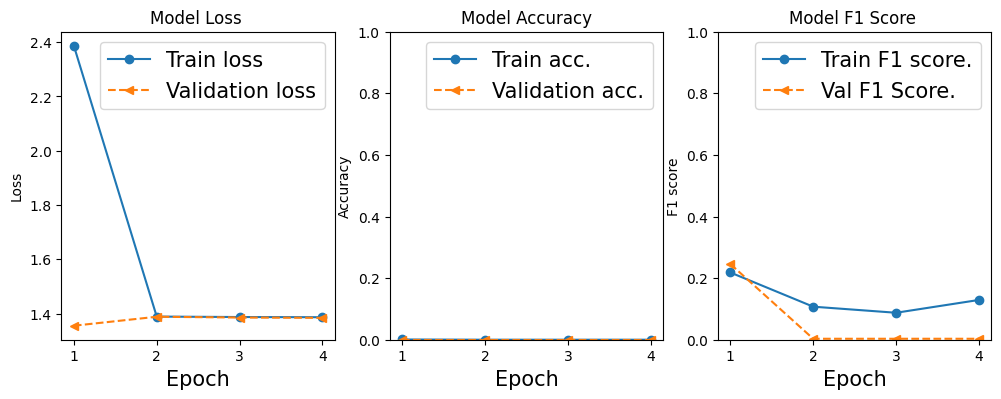

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  988
predicted_labels length :  988
confusion matrix shape= (4, 4)


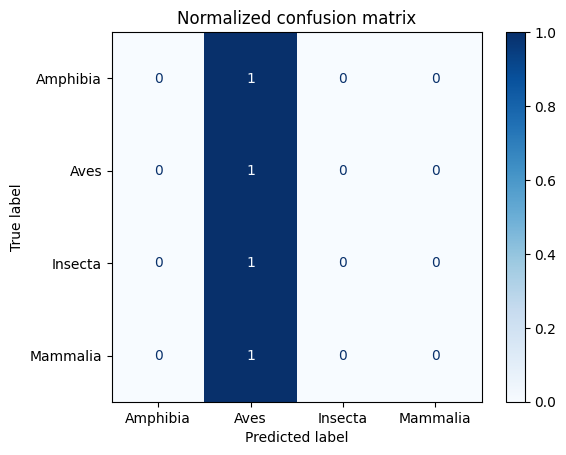

              precision    recall  f1-score   support

    Amphibia       0.00      0.00      0.00       134
        Aves       0.72      1.00      0.83       707
     Insecta       0.00      0.00      0.00        93
    Mammalia       0.00      0.00      0.00        54

    accuracy                           0.72       988
   macro avg       0.18      0.25      0.21       988
weighted avg       0.51      0.72      0.60       988



In [62]:
evaluation_model = build_evaluation_model(X_under_cnn.shape[1],y_under_cnn.shape[1])

# train model on (X_train, y_train) data
history = evaluation_model.fit(
    X_under_cnn,
    y_under_cnn,
    validation_data=(X_common_val,y_class_val),
    callbacks=[early_stopping_f1, reduce_lr_f1],
    batch_size=32,
    class_weight=under_cnn_class_weights_dict,
    epochs=20)

# plot loss curves
show_history(history)

#plot confusion matrix
plot_confusion_matrix(evaluation_model, X_under_cnn, y_under_cnn)

In [67]:
result_eval = evaluation_model.evaluate(X_under_cnn,
                          y_under_cnn,
                                        return_dict=True)


print("evaluation results = ", result_eval)
print('\nTest Acc. {:.4f}%'.format(result_eval.get('accuracy')*100))
print('\nTest F1-score MACRO. {:.4f}%'.format(result_eval.get('f1_score')*100))



31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - f1_score: 0.1744 - loss: 1.3620
evaluation results =  {'accuracy': 0.0, 'f1_score': 0.20855455100536346, 'loss': 1.367490530014038}

Test Acc. 0.0000%

Test F1-score MACRO. 20.8555%


We observe that the final model shows no significant improvement over the previous runs. Future steps, time permitting might include using higher resolution image data and a more advanced model architecture and data augmentation.